# Sentiment Analysis on Twitter data

Project by Sabrina Fonseca Pereira, Ida Maria Zachariassen, Magnus Sverdrup, Rasmus Bondo Hansen and Ruben Oliver Jonsman


# Introduction

The project presented in this notebook was developed with the purpose of predicting the intention or state of mind (pragmatics) of social media data from Twitter.

The data was provided from the [TweetEval](https://github.com/cardiffnlp/tweeteval/) corpus, a collection of 7 datasets for different classification tasks. Each task had test, train and validation datafiles consisting of one tweet per line with corresponding labelling in a separate file. Given a tweet we were to predict a label, based on a model trained on tokens of our data.

More precisely this project aims to predict the label of the binary classification task **Irony** and the multi class classification task **Stance**, specifically **Atheism**.
The **Irony** tweets to either be labelled as <code>0 - non_irony</code> or <code>1 - irony</code> and the **Atheism** tweets to either be labelled as <code>0 - none</code>, <code>1 - against</code> or <code>2 - favor</code>.
For further testing the possibility of predicting stance, all topics in the *Stance* task were gathered to see if it was possible to detect both topic and stance, getting a total of 15 labels.

---

# Required Libraries

In [33]:
import re
import numpy as np
import pandas as pd
import collections as cl
from collections import Counter
import difflib as dl
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

import nltk
import nltk.tokenize
from nltk.metrics.agreement import AnnotationTask
from nltk.tokenize import TweetTokenizer
from nltk.util import everygrams
from nltk.lm.preprocessing import flatten, padded_everygram_pipeline, pad_both_ends
from nltk.lm import MLE
from nltk.util import ngrams
from nltk.probability import FreqDist

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases

In [36]:
# setting theme for all plots
sns.set_theme(style="darkgrid")

# Consistent variables

## Paths to the data

In [37]:
PATHS = {}

#Path to the irony datasets
PATHS["irony"] = "./datasets/irony/{}.txt"

#Path to the stance datasets
PATHS["stance"] = "./datasets/stance/{}.txt"

#Path to the combined stance dataset
PATHS["combined_stance"] = "./processed/stance/{}"

#Path to our manual annotation answers
PATHS["MAA"] = "./processed/{}.csv"

# Dataframes

## Irony

In [38]:
labels_irony = pd.read_csv(PATHS["irony"].format("mapping"), delimiter = "\t", header = None)

In [39]:
train_irony = pd.read_csv(PATHS["irony"].format("train_text"), delimiter = "\0", header = None, names = ["tweets"])
train_irony_labels = pd.read_csv(PATHS["irony"].format("train_labels"), delimiter = "\0", header = None, names=["labels"])
test_irony = pd.read_csv(PATHS["irony"].format("test_text"), delimiter = "\0", header = None, names = ["tweets"])
test_irony_labels = pd.read_csv(PATHS["irony"].format("test_labels"), delimiter = "\0", header = None, names=["labels"])
validation_irony = pd.read_csv(PATHS["irony"].format("val_text"), delimiter = "\0", header = None, names = ["tweets"])
val_irony_labels = pd.read_csv(PATHS["irony"].format("val_labels"), delimiter = "\0", header = None, names=["labels"])

Split irony training dataset into two subsets. One for creating our tokenizers and one for evaluating them

In [40]:
eval_tokenizer = train_irony[len(train_irony)-101:len(train_irony)-1]
train_irony = train_irony[0:len(train_irony)-100]

## Stance

In [41]:
labels_stance = pd.read_csv(PATHS["stance"].format("mapping"), delimiter = "\t", header = None)

##### Abortion

In [42]:
train_abortion = pd.read_csv(PATHS["stance"].format("/abortion/train_text"), delimiter = "\0", header = None, names = ["tweets"])
train_abortion_labels = pd.read_csv(PATHS["stance"].format("/abortion/train_labels"), delimiter = "\0", header = None, names=["labels"])
test_abortion = pd.read_csv(PATHS["stance"].format("/abortion/test_text"), delimiter = "\0", header = None, names = ["tweets"])
test_abortion_labels = pd.read_csv(PATHS["stance"].format("/abortion/test_labels"), delimiter = "\0", header = None,names=["labels"])
validation_abortion = pd.read_csv(PATHS["stance"].format("/abortion/val_text"), delimiter = "\0", header = None, names = ["tweets"])
validation_abortion_labels = pd.read_csv(PATHS["stance"].format("/abortion/val_labels"), delimiter = "\0", header = None, names=["labels"])

##### Atheism

In [43]:
train_atheism = pd.read_csv(PATHS["stance"].format("/atheism/train_text"), delimiter = "\0", header = None, names = ["tweets"])
train_atheism_labels = pd.read_csv(PATHS["stance"].format("/atheism/train_labels"), delimiter = "\0", header = None, names=["labels"])
test_atheism = pd.read_csv(PATHS["stance"].format("/atheism/test_text"), delimiter = "\0", header = None, names = ["tweets"])
test_atheism_labels = pd.read_csv(PATHS["stance"].format("/atheism/test_labels"), delimiter = "\0", header = None, names=["labels"])
validation_atheism = pd.read_csv(PATHS["stance"].format("/atheism/val_text"), delimiter = "\0", header = None, names = ["tweets"])
validation_atheism_labels = pd.read_csv(PATHS["stance"].format("/atheism/val_labels"), delimiter = "\0", header = None, names=["labels"])

##### Climate

In [44]:
train_climate = pd.read_csv(PATHS["stance"].format("/climate/train_text"), delimiter = "\0", header = None, names = ["tweets"])
train_climate_labels = pd.read_csv(PATHS["stance"].format("/climate/train_labels"), delimiter = "\0", header = None, names=["labels"])
test_climate = pd.read_csv(PATHS["stance"].format("/climate/test_text"), delimiter = "\0", header = None, names = ["tweets"])
test_climate_labels = pd.read_csv(PATHS["stance"].format("/climate/test_labels"), delimiter = "\0", header = None, names=["labels"])
validation_climate = pd.read_csv(PATHS["stance"].format("/climate/val_text"), delimiter = "\0", header = None, names = ["tweets"])
validation_climate_labels = pd.read_csv(PATHS["stance"].format("/climate/val_labels"), delimiter = "\0", header = None, names=["labels"])

##### Feminist

In [45]:
train_feminist = pd.read_csv(PATHS["stance"].format("/feminist/train_text"), delimiter = "\0", header = None, names = ["tweets"])
train_feminist_labels = pd.read_csv(PATHS["stance"].format("/feminist/train_labels"), delimiter = "\0", header = None, names=["labels"])
test_feminist = pd.read_csv(PATHS["stance"].format("/feminist/test_text"), delimiter = "\0", header = None, names = ["tweets"])
test_feminist_labels = pd.read_csv(PATHS["stance"].format("/feminist/test_labels"), delimiter = "\0", header = None, names=["labels"])
validation_feminist = pd.read_csv(PATHS["stance"].format("/feminist/val_text"), delimiter = "\0", header = None, names = ["tweets"])
validation_feminist_labels = pd.read_csv(PATHS["stance"].format("/feminist/val_labels"), delimiter = "\0", header = None, names=["labels"])

##### Hillary

In [46]:
train_hillary = pd.read_csv(PATHS["stance"].format("/hillary/train_text"), delimiter = "\0", header = None, names = ["tweets"])
train_hillary_labels = pd.read_csv(PATHS["stance"].format("/hillary/train_labels"), delimiter = "\0", header = None, names=["labels"])
test_hillary = pd.read_csv(PATHS["stance"].format("/hillary/test_text"), delimiter = "\0", header = None, names = ["tweets"])
test_hillary_labels = pd.read_csv(PATHS["stance"].format("/hillary/test_labels"), delimiter = "\0", header = None, names=["labels"])
validation_hillary = pd.read_csv(PATHS["stance"].format("/hillary/val_text"), delimiter = "\0", header = None, names = ["tweets"])
validation_hillary_labels = pd.read_csv(PATHS["stance"].format("/hillary/val_labels"), delimiter = "\0", header = None, names=["labels"])

## Manual annotation answers for the irony dataset

In [47]:
MAA = pd.read_csv(PATHS["MAA"].format("manual_annotations"))
MAA = MAA.drop('Unnamed: 0', 1)

# 1. Preprocessing

Tokenization is the task of splitting a string of characters into minimal processed units, also called tokens, which will be the input in our machine learning solutions.
As a starting point we aimed at segmenting the lines at “words” and turned to discuss the significance of written language on social media platforms like Twitter. 

We saw that our ideal tokenizer should:
* Keep words
* Remove emojis
* Keep numbers
* Make everything lower case

Further interesting tokenizers were:
* Only #
* Only Non-words
* Only Uppercase letters
* Only emojis

We did this using the RegEx module. 

We lastly compared the output of our final tokenizer with a baseline [tweet tokenizer](https://www.nltk.org/api/nltk.tokenize.html) from the NLTK library. To investigate this we used the difflib library. Here each token is compared and the difference between them displayed.

## Tokenizers

In [48]:
def tokenize_ideal(line):
    """
    Takes a string as an input, this is a line or a tweet from our database. Splits the relevant words or characters into
    separate tokens.
    Returns either the tokens as a whitespace delimited string or as a list of the tokens. Also returns the non tokens as a list
    
    Keeps words, ?, !, ..., +, - and turns & into "and"
    removes dots, commas, # and %
    """
    tokens = []
    unmatchables = []
    
    for word in line.split():
        if re.findall(r"\w+-\w+|\w+'\w+|\w+|[&?!…]+", word) != []:
            x = re.findall(r"\w+-\w+|\w+'\w+|\w+|[&?!…]+", word)
            for element in x:
                if element == "âž" or element == "ðŸ":
                    continue
                elif element == "&":
                    tokens.append("and")
                else:
                    tokens.append(element.lower())

        if re.findall(r"\w+-\w+|\w+'\w+|\w+|[&?!…]", word) != [word] and re.findall(r"[^\w|&!?…]+", word) != []:
            unmatchables.append(re.findall(r"[^\w|!?…&]+", word)[0])

    s = " ".join(tokens)
    return (s, unmatchables, tokens)

In [49]:
def tokenize_ekstra(line):
    """
    Works same way as tokenize_ideal
    
    Keeps words, dots, ?, %, !, #, ..., +, - and turns & into "and"
    Removes emojies and commas
    """
    tokens = []
    unmatchables = []
    
    for word in line.split():
        if re.findall(r"\w+-\w+|\w+'\w+|\w+|[.&?%!#…]+", word) != []:
            x = re.findall(r"\w+-\w+|\w+'\w+|\w+|[.&?%!#…]+", word)
            for element in x:
                if element == "âž" or element == "ðŸ":
                    continue
                elif element == "&":
                    tokens.append("and")
                else:
                    tokens.append(element.lower())

        if re.findall(r"\w+-\w+|\w+'\w+|\w+|[.&?%!#…]", word) != [word] and re.findall(r"[^\w|.&!?%#…]+", word) != []:
            unmatchables.append(re.findall(r"[^\w|.!#?%…&]+", word)[0])

    s = " ".join(tokens)
    return (s, unmatchables, tokens)

In [50]:
def tokenizer_caps(data):
    """
    Finds words that only consist of uppercase letters
    """

    tokens = []
    unmatchable = []

    line = data[:500]
    #print(line)
    skip_pat = re.compile(r'\s+')
    token_pat = re.compile(r'\b[A-Z]+\b')

    while line:

        skip_match = re.search(skip_pat, line)
        if skip_match and skip_match.start() == 0:
            line = line[skip_match.end():]
        else:
            token_match = re.search(token_pat, line)
            if token_match and token_match.start() == 0:
                tokens.append(line[:token_match.end()])
                line = line[token_match.end():]
            else:
                unmatch_end = len(line)
                if skip_match:
                    unmatch_end = skip_match.start()
                if token_match:
                    unmatch_end = min(unmatch_end, token_match.start())

                unmatchable.append(line[:unmatch_end])
                line = line[unmatch_end:]

    return tokens

In [51]:
def nonword_only_tokenizer(listofstrings):
    """
    Keeps tokens that are not normal words
    """
    tokens = []
    unmatchables = []

    for string in listofstrings:
        tokens.append(re.findall(r'[^a-zA-Z\s]', string))
        unmatchables.append(re.findall(r'[\w]+', string))

    return (tokens, unmatchables)

In [52]:
def hashtag_only_tokenizer(listofstrings):
    """
    Keeps only the hastagged words
    """
    tokens = []
    unmatchables = []

    for string in listofstrings:
        hashtags = re.findall(r'#(\w+)', string)
        tokens.append(hashtags)

        not_hashtags = []
        all_words = re.findall(r'\w+', string)
        for word in all_words:
            if word not in hashtags:
                not_hashtags.append(word)
        unmatchables.append(not_hashtags)

    return (tokens, unmatchables)

In [53]:
EMOJI = "[\U00010000-\U0010ffff]"
NOT_EMOJI = r'[^\U00010000-\U0010ffff]+'
EMOJICON = r"(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)"
# EMOJICON-regex found on: https://stackoverflow.com/questions/28077049/regex-matching-emoticons

def emoji_cons(tweet):
    """
    Keeps tokens that are emojis or emojicons
    """
    tokens = []
    unmatchables = []

    for string in tweet:
        if re.findall(EMOJI, string) != []:
            x = re.findall(EMOJI, string)
            for element in x:
                tokens.append(re.findall(EMOJI, string))
        elif re.findall(EMOJICON, string) != []:

            tokens.append(re.findall(EMOJICON, string))
    if re.findall(EMOJICON, tweet) != []:
        tokens.append(re.findall(EMOJICON, tweet))

    if re.findall(NOT_EMOJI, tweet) != [] and re.findall(NOT_EMOJI, tweet) not in tokens:
        unmatchables.append(re.findall(NOT_EMOJI, tweet))

    return (tokens, unmatchables)

We have created a few different tokenizers. However, to illsutrate our work we will through most of the notebook stick with our "tokenize_ideal" tokenizer. In the end when we have created our ML models to predict stance and irony, we will compare the different tokenizers and evaluate which one is the best. <br>
<br>
Here is a small sample when using our "tokenize_ideal" function:

In [54]:
tokens = []
tokens_list = []
tokens_string = []
unmatches = []
for tweet in list(eval_tokenizer["tweets"]):
    tokenized = tokenize_ideal(tweet)
    tokens_list.append(tokenized[2])
    tokens_string.append(tokenized[0])
    for token in tokenized[2]:
        tokens.append(token)
    for un in tokenized[1]:
        unmatches.append(un)

print(tokens_list[0:5])   

[['user', 'why', "don't", 'you', 'tarmac', 'all', 'the', 'speed', 'humps', 'in', 'the', 'cut', 'in', '1', 'go', 'instead', 'of', 'bit', 'by', 'bit', 'as', 'the', 'brickwork', 'disintegrates', '!', 'science'], ['ready', 'for', 'the', 'tax', 'final'], ['gotta', 'study', 'and', "i'm", 'like', 'who', 'cares', '?!', 'perksofbeingasenior'], ['user', "i'm", 'relaxed', 'and', 'waiting', 'for', 'the', 'facts', 'to', 'come', 'out', 'but', "i've", 'listened', 'to', 'blaine', 'hammer', 'on', 'players', 'for', 'doing', 'similar', 'before'], ['i', 'was', 'going', '2', 'post', 'my', 'opinions', 'on', 'obama', 'cuba', 'but', 'i', 'will', 'save', 'it', 'till', 'after', 'his', 'speech', 'peacemaker']]


## Comparison with baseline tokenizer

To understand how general tokenizers work, and to figure out the quality of our own tokenizers, we wanted to compare our tokenizers with a baseline tokenisation tool. Here we use the social media tokeniser called TweetTokenizer from the nltk library: https://www.nltk.org/api/nltk.tokenize.html. Since we removed a small part from the training dataset in the begnining, we now have some tweets to evaluate our tokenizers and compare our tokenizers.

In [55]:
tknzr = TweetTokenizer()

In [56]:
nltk_tokens = []
nltk_list = []
for tweet in list(eval_tokenizer["tweets"]):
    tokenized = tknzr.tokenize(tweet)
    nltk_list.append(tokenized)
    for token in tokenized:
        nltk_tokens.append(token)
print(nltk_list[0:5])

[['@user', 'Why', "don't", 'you', 'Tarmac', 'all', 'the', 'speed', 'humps', 'in', 'The', 'Cut', 'in', '1', 'go', 'instead', 'of', 'bit', 'by', 'bit', 'as', 'the', 'brickwork', 'disintegrates', '!', '|', '🚀', 'Science'], ['Ready', 'for', 'the', 'tax', 'final'], ['Gotta', 'study', 'and', "I'm", 'like', ',', 'who', 'cares', '?', '!', '#perksofbeingasenior', '👎'], ['@user', "I'm", 'relaxed', ',', 'and', 'waiting', 'for', 'the', 'facts', 'to', 'come', 'out', '.', 'But', "I've", 'listened', 'to', 'Blaine', 'hammer', 'on', 'players', 'for', 'doing', 'similar', 'before', '.'], ['I', 'was', 'going', '2', 'post', 'my', 'opinions', 'on', '#obama', '#cuba', 'but', 'i', 'will', 'save', 'it', ',', 'till', 'after', 'his', '#speech', '.', '#peacemaker']]


To see the difference quantitatively we can use the method SequenceMatcher from the difflib library: https://docs.python.org/3/library/difflib.html

In [57]:
match_ratio = []
for i in range(len(tokens_list)):
    match_ratio.append(dl.SequenceMatcher(None, nltk_list[i], tokens_list[i]).ratio())
print("Average ratio:",np.mean(match_ratio))    

Average ratio: 0.654476627294648


Here we see that on average our tokenizer and the NLTK baseline tokenizer agree 65% of the time. However, none of these two methods are perfect, and this number of 65% is not really good/bad or high/low. Alternativly we can also look at the actual difference between the two tokenizers.<br>
<br>
Here we again use the difflib library, now a method called unified_diff, which returns the area where there differences occur. As an example we only look at the first tweet. <br>
<code>"+"</code> means that the word is present in the output from the baseline tokenizer but not in the output from our tokenizer. <br>
<code>"-"</code> means that the word is not present in the output from the baseline tokenizer but it is in our tokenizer.

In [58]:
n = 1
for i in range(n):
    print("Our tokenized tweet:\0", tokens_list[i], "\0")
    print("NLTK tokenized tweed:\0", nltk_list[i], "\0")
    print("Difference between the two:")
    for diff in dl.unified_diff(tokens_list[i], nltk_list[i]):
        print(diff, "\0")

Our tokenized tweet:  ['user', 'why', "don't", 'you', 'tarmac', 'all', 'the', 'speed', 'humps', 'in', 'the', 'cut', 'in', '1', 'go', 'instead', 'of', 'bit', 'by', 'bit', 'as', 'the', 'brickwork', 'disintegrates', '!', 'science']  
NLTK tokenized tweed:  ['@user', 'Why', "don't", 'you', 'Tarmac', 'all', 'the', 'speed', 'humps', 'in', 'The', 'Cut', 'in', '1', 'go', 'instead', 'of', 'bit', 'by', 'bit', 'as', 'the', 'brickwork', 'disintegrates', '!', '|', '🚀', 'Science']  
Difference between the two:
--- 
  
+++ 
  
@@ -1,15 +1,15 @@
  
-user  
-why  
+@user  
+Why  
 don't  
 you  
-tarmac  
+Tarmac  
 all  
 the  
 speed  
 humps  
 in  
-the  
-cut  
+The  
+Cut  
 in  
 1  
 go  
@@ -23,4 +23,6 @@
  
 brickwork  
 disintegrates  
 !  
-science  
+|  
+🚀  
+Science  


It can however be seen that the comparing is case sensitive, which causes the biggest difference, as it was decided to lower case everything in our tokenizer. <br>
To summerize, our chosen tokenizer actually removes more than the baseline. In the end we will conclude if this makes a difference when predicting.

# 2. Characterising Your Data

We create a function to quickly report the number of lines, words and characters in case unix commands for macs doesn't work.

In [59]:
def word_count(class_string, data_string):
    """Shows the details that wc unix command would show: 
    amount of lines, words and characters for the stance datasets."""
    
    file = open("./datasets/"+ data_string +"/train_text.txt", "r", encoding = "utf-8")

    num_lines = 0; num_words = 0; num_char = 0
    for line in file:
        line = line.strip("\0")

        words = line.split()
        num_lines += 1
        num_words += len(words)
        num_char += len(line)

    print(num_lines, num_words, num_char)
    print("Number of lines, words and characters in the training text file for the", class_string, data_string, "\0")

    with open("./datasets/"+ data_string +"/train_labels.txt", "r") as file:
        filelist = file.read().split("\0")

    print(len(filelist))
    print("Number of lines in the training label file for the", class_string, data_string)

To simplify our process of finding statistics we create a function to quickly create a vocabulary for a given dataset.

In [60]:
def vocabulary(tokens):
    vocabulary = pd.DataFrame()
    vocabulary_counter = cl.Counter(tokens)
    vocabulary["word"] = vocabulary_counter.keys()
    vocabulary["frequency"] = vocabulary_counter.values()
    vocabulary = vocabulary.sort_values(by = ["frequency"], ascending = False)
    
    return vocabulary

## Irony
Corpus, vocabulary and token-ratio

### Corpus size

In [61]:
# Unix commands that work for mac
!wc "./datasets/irony/train_text.txt"
print("Number of lines, words and characters in the training text file for the binary class Irony. \0")

!wc -l "./datasets/irony/train_labels.txt"
print("Number of lines in the training label file for the binary class Irony.")

  2861  38939 231593 ./datasets/irony/train_text.txt
Number of lines, words and characters in the training text file for the binary class Irony.  
2861 ./datasets/irony/train_labels.txt
Number of lines in the training label file for the binary class Irony.


In [62]:
# Displays the above with distinction that it is viewable with windows os.
word_count("binary", "irony")

2862 38939 229673
Number of lines, words and characters in the training text file for the binary irony  
1
Number of lines in the training label file for the binary irony


In [63]:
sum_irony = len(train_irony) + len(test_irony) + len(validation_irony)
print((len(test_irony)/sum_irony)*100)

17.418351477449455


### Count of tweets per label

In [64]:
irony_train = pd.concat([train_irony, train_irony_labels], axis=1)
irony_val   = pd.concat([validation_irony, val_irony_labels], axis=1)
irony_test  = pd.concat([test_atheism,  test_irony_labels],  axis=1)

In [65]:
irony_train['labels'].value_counts()

1    1445
0    1417
Name: labels, dtype: int64

In [66]:
irony_val['labels'].value_counts()

0    499
1    456
Name: labels, dtype: int64

In [67]:
irony_test['labels'].value_counts()

0    473
1    311
Name: labels, dtype: int64

### Token-ratio

First tokenizing all the tweets in the <i>Irony</i> class using the <code>Tokenize_ideal</code> function, then creating a corresponding vocabulary and the unique token frequency.

In [68]:
irony_tokens = []
irony_tokens_list = []
irony_unmatches = []

for tweet in train_irony["tweets"]:
    tokenized = tokenize_ideal(tweet)
    irony_tokens_list.append(tokenized[2])
    for token in tokenized[2]:
        irony_tokens.append(token)
    for un in tokenized[1]:
        irony_unmatches.append(un)

In [69]:
irony_vocabulary = vocabulary(irony_tokens)
print("Number of tokens: ", sum(irony_vocabulary["frequency"]))
print("Number of unique tokens: ", len(irony_vocabulary["frequency"]))
irony_vocabulary

Number of tokens:  38428
Number of unique tokens:  8048


,word,frequency
41,user,1668
10,the,1046
27,to,923
58,a,780
35,i,740
...,...,...
275,goodellmustgo,1
3980,entrance,1
3979,gaining,1
3977,whould,1


Most frequent tokens in our vocabulary and their corresponding occurences.

In [70]:
print(list(irony_vocabulary["word"])[0:10])
print(list(irony_vocabulary["frequency"])[0:10])

['user', 'the', 'to', 'a', 'i', 'and', 'is', 'in', 'you', 'of']
[1668, 1046, 923, 780, 740, 585, 498, 451, 439, 427]


Amount of least occuring tokens and examples hereof.

In [71]:
for i in range(1,11):
    print("Amount of tokens occurring", i,"time(s):", len(irony_vocabulary[irony_vocabulary["frequency"] == i]))

Amount of tokens occurring 1 time(s): 5292
Amount of tokens occurring 2 time(s): 1085
Amount of tokens occurring 3 time(s): 444
Amount of tokens occurring 4 time(s): 291
Amount of tokens occurring 5 time(s): 161
Amount of tokens occurring 6 time(s): 121
Amount of tokens occurring 7 time(s): 70
Amount of tokens occurring 8 time(s): 60
Amount of tokens occurring 9 time(s): 52
Amount of tokens occurring 10 time(s): 37


In [72]:
for i in range(1, 6):
    print("5 tokens occuring", i, "time(s) \0", irony_vocabulary["word"][irony_vocabulary["frequency"] == i][:5], "\0")

5 tokens occuring 1 time(s)   5941    overspend
5945      crosses
5944       morgan
5943          ipa
7736         24hr
Name: word, dtype: object  
5 tokens occuring 2 time(s)   3313       soul
3321    burrito
3481     flight
3319      hills
3318     canada
Name: word, dtype: object  
5 tokens occuring 3 time(s)   2938         libby
2036             e
1010         gunna
199     accounting
4484         enter
Name: word, dtype: object  
5 tokens occuring 4 time(s)   1470       large
1477    mornings
1504     explain
4126        dark
1505     muslims
Name: word, dtype: object  
5 tokens occuring 5 time(s)   488        com
343     simply
1866     sound
2179      case
2427    killed
Name: word, dtype: object  


### Frequency table
Accumulating the frequency for each word in the vocabulary dataframe.

In [73]:
accu = []
count = 0
for i in range(len(irony_vocabulary["frequency"])):
    count = count + list(irony_vocabulary["frequency"])[i]
    accu.append(count/len(irony_tokens))
    
irony_vocabulary["cumulative_frequency"] = accu

In [74]:
irony_vocabulary["rank"] = [i+1 for i in range(len(irony_vocabulary["word"]))]
irony_vocabulary

,word,frequency,cumulative_frequency,rank
41,user,1668,0.043406,1
10,the,1046,0.070626,2
27,to,923,0.094645,3
58,a,780,0.114942,4
35,i,740,0.134199,5
...,...,...,...,...
275,goodellmustgo,1,0.999896,8044
3980,entrance,1,0.999922,8045
3979,gaining,1,0.999948,8046
3977,whould,1,0.999974,8047


Plotting the cummulative count for the tokens.

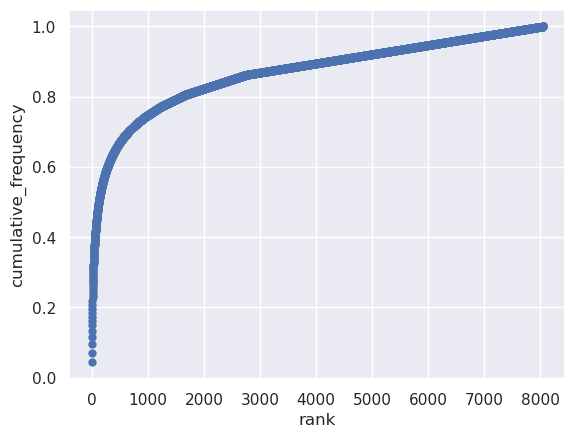

In [75]:
sns.scatterplot(x = irony_vocabulary["rank"], y = irony_vocabulary["cumulative_frequency"], linewidth=0);

##### Illustration of Zipf's law <br>
"*given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word.*", this quote is taken from [Wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law). With this law, we can expect that very few words make up the biggest part of any given context. To verify this claim, one can in a log-log transformed system plot the frequency of each token against the tokens rank. This should create something close to a straight line. <br>
<br>
Therefore we add two new columns to our vocabulary dataframe, each is the log transformed values for the frequency and the rank.

In [76]:
irony_vocabulary["log_frequency"] = np.log(irony_vocabulary["frequency"])
irony_vocabulary['log_rank'] = np.log(irony_vocabulary["rank"])
#vocabulary

By plotting the log frequency and the log rank we see an almost linear relationship between the tokens.

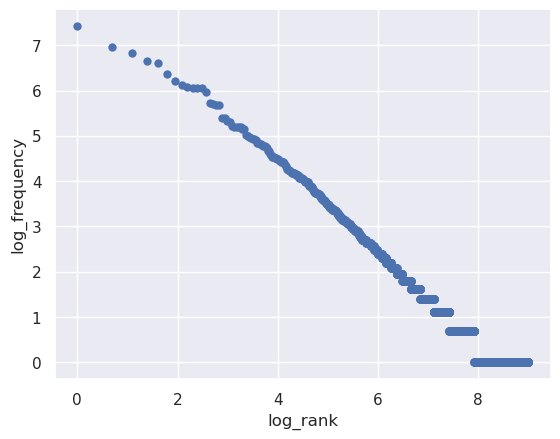

In [77]:
sns.scatterplot(data = irony_vocabulary, x = "log_rank", y = "log_frequency", linewidth=0);

In [78]:
N = irony_vocabulary['frequency'].sum()
irony_vocabulary['proportion'] = irony_vocabulary['frequency']/N
irony_vocabulary['predicted_proportion'] = (1/irony_vocabulary['rank']**1)/(np.sum(1/(np.arange(1, N+1)**1))) # zipfs prediction

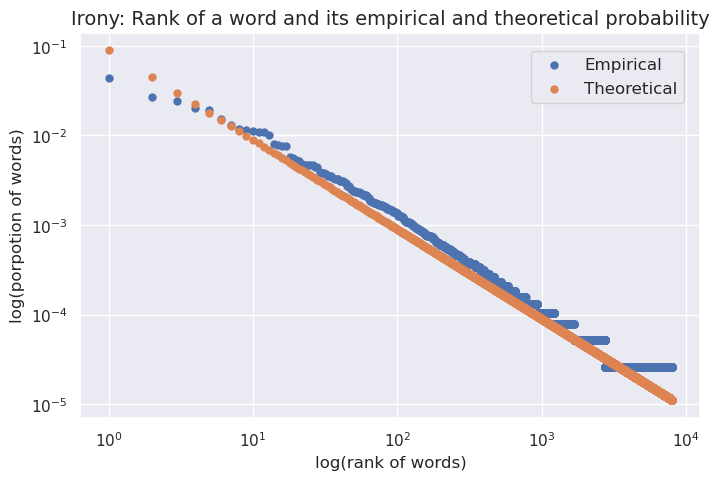

In [79]:
fig_irony, a = plt.subplots(figsize = (8,5))
a = sns.scatterplot(x=irony_vocabulary["rank"], y=irony_vocabulary['proportion'], linewidth=0)
a = sns.scatterplot(x=irony_vocabulary["rank"], y=irony_vocabulary['predicted_proportion'], linewidth=0)
a.set(yscale="log", xscale="log")
plt.xlabel("log(rank of words)")
plt.ylabel("log(porpotion of words)")
plt.title("Irony: Rank of a word and its empirical and theoretical probability", size=14)
fig_irony.legend(labels=['Empirical', 'Theoretical'], bbox_to_anchor=(.89, .86), fontsize=12)
plt.show(fig_irony)

### N-Grams
To investigate the relationship between words, we are going to use n-grams. This method is explained through the Markov assumption: "*Each element of the sequence depends only on the immediately preceding element and is independent of the previous history*". With this we can define the k'th order Markov assumption: "*Each element of the sequence depends only on the k immediately preceding elements.*" <br>
<br>
With this tool we can define the probabilities of k preceding words for every unique word in a given context. When we are able to predict words, we are also able to predict meaning or context of new sentences. As mentioned we will be using n-grams in our project which comes from the python library NLTK which has multiple n-gram implementations.

To begin we are going to look at a bigram. To prepare every tweet for the n-gram model, we have to pad them. Meaning we are putting a "s" (start of sentence) symbol at the front, and a "/s" (end of sentence) symbol at the end. This can give meaning to words that tend to appear more often in the beginning or at the end. <br>
<br>
Here we see a "bigram", which is just a n-gram with degree of 2. Meaning we are only looking 1 word back in the sentence, for every word. For example the word "walking" is in this case being related to the preceding word "ppl". 

In [80]:
ex2 = list(nltk.bigrams(pad_both_ends(irony_tokens_list[0], n = 2)))
print(ex2)

[('<s>', 'seeing'), ('seeing', 'ppl'), ('ppl', 'walking'), ('walking', 'w'), ('w', 'crutches'), ('crutches', 'makes'), ('makes', 'me'), ('me', 'really'), ('really', 'excited'), ('excited', 'for'), ('for', 'the'), ('the', 'next'), ('next', '3'), ('3', 'weeks'), ('weeks', 'of'), ('of', 'my'), ('my', 'life'), ('life', '</s>')]


This is an example of a trigram, n-gram with degree of 3. Here we are looking and defining based on the 2 preceding words.

In [81]:
ex3 = list(nltk.trigrams(pad_both_ends(irony_tokens_list[0], n = 3)))
print(ex3)

[('<s>', '<s>', 'seeing'), ('<s>', 'seeing', 'ppl'), ('seeing', 'ppl', 'walking'), ('ppl', 'walking', 'w'), ('walking', 'w', 'crutches'), ('w', 'crutches', 'makes'), ('crutches', 'makes', 'me'), ('makes', 'me', 'really'), ('me', 'really', 'excited'), ('really', 'excited', 'for'), ('excited', 'for', 'the'), ('for', 'the', 'next'), ('the', 'next', '3'), ('next', '3', 'weeks'), ('3', 'weeks', 'of'), ('weeks', 'of', 'my'), ('of', 'my', 'life'), ('my', 'life', '</s>'), ('life', '</s>', '</s>')]


We can also combine the bigram and trigram to create everygrams. Like this we also include the lower degrees of grams. If we for example use a everygram with degree of 3, we not only create the trigram, but we also include the bigram and unigram information.

In [82]:
padded_bigrams = list(pad_both_ends(irony_tokens_list[0], n=2))
ex_every = list(everygrams(padded_bigrams, max_len=3))
print(ex_every)

[('<s>',), ('<s>', 'seeing'), ('<s>', 'seeing', 'ppl'), ('seeing',), ('seeing', 'ppl'), ('seeing', 'ppl', 'walking'), ('ppl',), ('ppl', 'walking'), ('ppl', 'walking', 'w'), ('walking',), ('walking', 'w'), ('walking', 'w', 'crutches'), ('w',), ('w', 'crutches'), ('w', 'crutches', 'makes'), ('crutches',), ('crutches', 'makes'), ('crutches', 'makes', 'me'), ('makes',), ('makes', 'me'), ('makes', 'me', 'really'), ('me',), ('me', 'really'), ('me', 'really', 'excited'), ('really',), ('really', 'excited'), ('really', 'excited', 'for'), ('excited',), ('excited', 'for'), ('excited', 'for', 'the'), ('for',), ('for', 'the'), ('for', 'the', 'next'), ('the',), ('the', 'next'), ('the', 'next', '3'), ('next',), ('next', '3'), ('next', '3', 'weeks'), ('3',), ('3', 'weeks'), ('3', 'weeks', 'of'), ('weeks',), ('weeks', 'of'), ('weeks', 'of', 'my'), ('of',), ('of', 'my'), ('of', 'my', 'life'), ('my',), ('my', 'life'), ('my', 'life', '</s>'), ('life',), ('life', '</s>'), ('</s>',)]


Now with the tweets prepared we can begin to train a model. To do this we have created a small function that takes the tokenized tweets and a degree of the everygram. Here we are using the pipeline function from NLTK which does the padding for us very easily.

In [83]:
def train_ngram(listoflistoftokens, n):
    train, vocab = padded_everygram_pipeline(n, listoflistoftokens)
    lm = MLE(n)
    lm.fit(train, vocab)
    return lm

We train two models, one with degree 3 and one with degree 2

In [84]:
lm3 = train_ngram(irony_tokens_list, 3)

To validate the models we can look at how confused it is when trying to predict on words. Here we use the NLTK perplexity function, the higher the score the more options the model has to choose from, meaning it is unsure what is most correct. To test this we feed the first sentence in the irony training dataset to the two models.

In [85]:
for i in ex_every:
    print(i)
    print(lm3.perplexity([i]))

('<s>',)
8.95655322230268
('<s>', 'seeing')
2762.000000000002
('<s>', 'seeing', 'ppl')
2.0
('seeing',)
4947.5999999999985
('seeing', 'ppl')
9.999999999999998
('seeing', 'ppl', 'walking')
1.0
('ppl',)
5497.333333333337
('ppl', 'walking')
9.000000000000002
('ppl', 'walking', 'w')
1.0
('walking',)
7068.0000000000055
('walking', 'w')
7.000000000000003
('walking', 'w', 'crutches')
1.0
('w',)
2748.666666666665
('w', 'crutches')
18.000000000000007
('w', 'crutches', 'makes')
1.0
('crutches',)
49476.00000000002
('crutches', 'makes')
1.0
('crutches', 'makes', 'me')
1.0
('makes',)
2061.5000000000014
('makes', 'me')
4.0
('makes', 'me', 'really')
6.0
('me',)
246.1492537313435
('me', 'really')
100.50000000000003
('me', 'really', 'excited')
2.0
('really',)
749.6363636363636
('really', 'excited')
22.0
('really', 'excited', 'for')
1.5000000000000002
('excited',)
3298.399999999999
('excited', 'for')
2.142857142857143
('excited', 'for', 'the')
3.5
('for',)
127.84496124031017
('for', 'the')
8.413043478260

For both models it seems to have an okay (low) perplexity with some of the words, but for others it has a high score, meaning it is very confused about what to predict here. <br>
<br>
Lastly we can also use these models to generate sentences based on the training data. The generated data is often hard to make sense of or just a copy of a tweet. This is probably due to the model being quite confused, or that there only exists one prediction for this specific case. When talking NLP we have to keep in mind that our training data is a small dataset, and therefore we would expect low performance.

In [86]:
print(lm3.generate(10))

['on', 'my', 'day', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


### Maximum likelihood

Maximum likelihood is about estimating preceding words in a given context. Meaning what is the probability of x given y. This is simply the sum of x given y in the corpus divied by the number of times y appear in the corpus:<br>

$$p(w_2|w_1) = \frac{\text{count}(w_1w_2)}{\text{count}(w_1\bullet)}$$
<br>
To illustrate the maximum liklihood principle, and the problems with it, we creating a subset of the irony training dataset. These tweets we tokenize, pad and create their bigrams and put into a list.

In [87]:
bigram_tokens = []
mx_test = list(train_irony["tweets"][0:100])
for tweet in mx_test:
    tokenized = tokenize_ideal(tweet)
    bigram_tokens.append(tokenized[2])
padded_bigram_tokens = []
for tokens in bigram_tokens:
    bi = list(nltk.bigrams(pad_both_ends(tokens, n = 2)))
    padded_bigram_tokens.append(bi)
flat_tokens = []
mm = [[flat_tokens.append(bigram) for bigram in line] for line in padded_bigram_tokens]

We then create a dictionary that stores every preceding word to every unique token in the corpus.

In [88]:
#def mx(tokens): (OBS: takes around 1 min to run)
uniques = list(irony_vocabulary["word"])
probs = {unique:[] for unique in uniques}
df = pd.DataFrame(irony_vocabulary["word"])
for unique in uniques:
    for bigram in flat_tokens:
        if bigram[-1] == unique:
            probs[unique].append(bigram[0])

Lastly we sum all the times the specific x given y appears and divide by the times y appears in the corpus.

In [89]:
dic = {key:{} for key in probs.keys()}
for key in probs:
    x = set(probs[key])
    for item in x:
        n = 0
        u = 0
        for i in flat_tokens:
            if item == i[0]:
                n += 1
            if item == i[0] and key == i[1]:
                u += 1
        dic[key].update({item:u/n})

We can then see all the probabilities of the preceding words for the token "user". For example, the probability of "user" given "user" is 34.5% percent, and the probability of "user" given "feat" is 100% percent. Meaning if our model wants try predict what word comes after the token "feat", then it will with 100% certainty predict the token "user". 

In [90]:
dic["user"]

{'with': 0.09090909090909091,
 'lol': 0.25,
 'if': 0.2,
 'a': 0.03571428571428571,
 'via': 1.0,
 'caring': 1.0,
 'bay': 1.0,
 'user': 0.3448275862068966,
 'online': 0.5,
 '<s>': 0.19,
 'open': 1.0,
 'thanks': 1.0,
 'the': 0.023255813953488372,
 'and': 0.045454545454545456,
 'bones': 1.0,
 'feat': 1.0,
 'gobolts': 1.0,
 'drop': 1.0,
 'rt': 0.5,
 '!!': 0.25,
 'follow': 0.5}

The reason for this model to predict "feat" as preciding "user" with 100% certainty is that "feat" only appears once in the corpus. This is obviously not good, since we know there are many more posibilities of words that can appear after "feat" than just "user" in future tweets. To tackle this problem we will discuss smoothing techniques next.

### Smoothing Techniques
Smoothing techniques in NLP are used to address scenarios related to determining probability / likelihood estimate of a sequence of words (say, a sentence) occuring together when one or more words individually (unigram) or N-grams such as bigram(wi/wi−1) or trigram (wi/wi−1wi−2) in the given set have never occured in the past.

##### Kneser–Ney smoothing
Kneser–Ney smoothing is a method primarily used to calculate the probability distribution of n-grams in a document based on their histories. It is widely considered the most effective method of smoothing due to its use of absolute discounting by subtracting a fixed value from the probability's lower order terms to omit n-grams with lower frequencies.

Relying on only the unigram frequency to predict the frequencies of n-grams leads to skewed results; however, Kneser–Ney smoothing corrects this by considering the frequency of the unigram in relation to possible words preceding it.

##### Kneser–Ney smoothing

In [91]:
# Kneser Ney with nltk - Sabrina 
# is this the right tokenized dataset to be using: irony_tokens_list?
trigrams = [ngrams(sent, 3) for sent in irony_tokens_list]
fdist = FreqDist([item for l in trigrams for item in l])
kneser_ney = nltk.KneserNeyProbDist(fdist)

# KneserNeyProbDist: Kneser-Ney estimate of a probability distribution. This is a version of back-off that counts how likely an n-gram is provided the n-1-gram had been seen in training. Extends the ProbDistI interface, requires a trigram FreqDist instance to train on. Optionally, a different from default discount value can be specified. The default discount is set to 0.75.

In [92]:
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['frequency']
df_fdist.index.name = 'n-grams'
df_fdist_sorted = df_fdist.sort_values(by=['frequency'], ascending=False).reset_index()
df_fdist_sorted['kneser_ney_prob'] = df_fdist_sorted['n-grams'].apply(kneser_ney.prob)
df_fdist_sorted

,n-grams,frequency,kneser_ney_prob
0,"(user, user, user)",208,0.467833
1,"(http, t, co)",22,0.965909
2,"(user, user, i)",18,0.038939
3,"(i, just, love)",11,0.301471
4,"(i, have, to)",11,0.209184
...,...,...,...
31248,"(when, someone, who)",1,0.041667
31249,"(clever, you, !)",1,0.250000
31250,"(user, clever, you)",1,0.250000
31251,"(water, right, now)",1,0.250000


### Custom word embedding

Information about word embedding was mostly found here: https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/ <br>
The code for the word embedding implementation was greatly inspired by this web post: https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/ <br>

Every word can be represented by a vector. Word embeddings are N-dimensional vectors that try to capture word-meaning and context in their values. For the vectors to be useful, they should for a vocabulary capture the meaning of the words, the relationship between words, and the context of different words as they are used naturally. <br>
<br>
To capture this we can encode different meanings to the words, and therefore represent each word as an N dimensional vector. Then the relation between each word is measured by the euclidean distance. <br>
<br>
If one manages to create meaningfull encodings and assigns the values of each word in a good way, it can help machine learning models. Meaning words that were not seen during training, but is known in the word embedding space, will not be the cause of the model not functioning. For example if a model is trained to recognise vectors for “car”, “van”, “jeep”, or “automobile”, it will still behave well to the vector for “truck” due to the similarity of the vectors. Word embedding only works well with alot of data, thereore we are going to need more data than just the irony training data. For the demonstration of word embedding we are going to use all the training data from "emotion", "hate", "irony", "offensive" and "sentiment" datasets, as well as the testing data from the "sentiment" dataset (because it provided a lot of data).

In [93]:
train_emotion = pd.read_csv("./datasets/emotion/train_text.txt", delimiter = "\0", names = ["tweet"])
train_hate = pd.read_csv("./datasets/hate/train_text.txt", delimiter = "\0", names = ["tweet"])
train_offensive = pd.read_csv("./datasets/offensive/train_text.txt", delimiter = "\0", names = ["tweet"])
train_sentiment = pd.read_csv("./datasets/sentiment/train_text.txt", delimiter = "\0", names = ["tweet"])
train_iron = pd.read_csv("./datasets/irony/train_text.txt", delimiter = "\0", names = ["tweet"])
test_sentiment = pd.read_csv("./datasets/sentiment/test_text.txt", delimiter = "\0", names = ["tweet"])
master = pd.concat([train_emotion, train_iron, train_hate, train_offensive, train_sentiment, test_sentiment])
len(master)

75433

With all this data combined we now have 75000 tweets. We then tokenize the tweets.

In [94]:
master_list = []
for tweet in master["tweet"]:
    tokenized = tokenize_ideal(tweet)
    master_list.append(tokenized[2])

In [95]:
all_sentences = master_list
common_terms = ["of", "with", "without", "and", "or", "the", "a", "it", "it's", "its"]
phrases = Phrases(all_sentences, connector_words = common_terms)
bigram = Phraser(phrases)
all_sentences = list(bigram[all_sentences])

We train our Word2Vec model with the tokenized master dataset. We set our vectors to have a dimension of 100, set the context window to be 5 words and exclude words that only appear once.

In [96]:
embed_model = Word2Vec(all_sentences, 
                 min_count=2,   # Ignore words that appear less than this
                 vector_size=100,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 epochs=30)       # Number of epochs training over corpus

In [97]:
embed_model.wv.vectors.shape[0]

35206

We see a vocabulary of 35206 unique words, which each appears more than once in the master dataset.

In [98]:
embed_model.wv.most_similar("good", topn = 10)

[('great', 0.6293189525604248),
 ('bad', 0.627475917339325),
 ('nice', 0.5467268824577332),
 ('decent', 0.5231650471687317),
 ('hard', 0.5111561417579651),
 ('weird', 0.4776473045349121),
 ('terrible', 0.45798444747924805),
 ('soft', 0.44285255670547485),
 ('real', 0.4426194727420807),
 ('solid', 0.4353356957435608)]

Now we can see the top words that are supposed to have similar context - often of same lexical category. One would expect the word "good" to lie next to words like "nice" and "great", and indeed our model is predicting this. However, it is also predicting the opposite meaning words like "bad" and "hard", as they are also words that could replace "good" and the sentence would probably still make sense.

## Stance: Atheism
Corpus, vocabulary and token-ratio

### Corpus size

In [99]:
!wc "./datasets/stance/atheism/train_text.txt"
print("Number of lines, words and characters in the training text file for the multi class Stance: atheism. \0")

!wc -l "./datasets/stance/atheism/train_labels.txt"
print("Number of lines in the training label file for the multi class Stance: atheism.")

  461  8388 50165 ./datasets/stance/atheism/train_text.txt
Number of lines, words and characters in the training text file for the multi class Stance: atheism.  
460 ./datasets/stance/atheism/train_labels.txt
Number of lines in the training label file for the multi class Stance: atheism.


In [100]:
# Displays the above with distinction that it is viewable with windows os.
word_count("multiclass", "stance/atheism")

461 8388 50165
Number of lines, words and characters in the training text file for the multiclass stance/atheism  
1
Number of lines in the training label file for the multiclass stance/atheism


In [101]:
sum_atheism = len(train_atheism) + len(test_atheism) + len(validation_atheism)
print((len(test_atheism)/sum_atheism)*100)

30.013642564802183


### Count of tweets per label

In [102]:
atheism_train = pd.concat([train_atheism, train_atheism_labels], axis=1)
atheism_val   = pd.concat([validation_atheism, validation_atheism_labels], axis=1)
atheism_test  = pd.concat([test_atheism,  test_atheism_labels],  axis=1)

In [103]:
atheism_train['labels'].value_counts()

1    273
0    105
2     83
Name: labels, dtype: int64

In [104]:
atheism_val['labels'].value_counts()

1    31
0    12
2     9
Name: labels, dtype: int64

In [105]:
atheism_test['labels'].value_counts()

1    160
2     32
0     28
Name: labels, dtype: int64

### Token-ration
Tokenizing the tweets of the <i>Stance: Atheism</i> class and creating the corresponding vocabulary as well as the token count.

In [106]:
atheism_tokens = []
atheism_tokens_list = []
atheism_unmatches = []
for tweet in train_atheism["tweets"]:
    tokenized = tokenize_ideal(tweet)
    atheism_tokens_list.append(tokenized[2])
    for token in tokenized[2]:
        atheism_tokens.append(token)
    for un in tokenized[1]:
        atheism_unmatches.append(un)

In [107]:
atheism_vocabulary = vocabulary(atheism_tokens)
print("Number of tokens: ", sum(atheism_vocabulary["frequency"]))
print("Number of unique tokens: ", len(atheism_vocabulary["frequency"]))

Number of tokens:  8560
Number of unique tokens:  2259


Most frequent tokens and their corresponding count in the vocabulary for the <i> Stance: Abortion </i> class.

In [108]:
print(list(atheism_vocabulary["word"])[0:10])
print(list(atheism_vocabulary["frequency"])[0:10])

['semst', 'the', 'to', 'of', 'and', 'you', 'is', 'user', 'god', 'in']
[461, 308, 186, 182, 176, 157, 140, 135, 135, 133]


Amount of least occuring tokens and examples hereof.

In [109]:
for i in range(1,11):
    print("Amount of tokens occurring", i,"times:", len(atheism_vocabulary[atheism_vocabulary["frequency"] == i]))

Amount of tokens occurring 1 times: 1481
Amount of tokens occurring 2 times: 308
Amount of tokens occurring 3 times: 126
Amount of tokens occurring 4 times: 74
Amount of tokens occurring 5 times: 53
Amount of tokens occurring 6 times: 34
Amount of tokens occurring 7 times: 23
Amount of tokens occurring 8 times: 18
Amount of tokens occurring 9 times: 15
Amount of tokens occurring 10 times: 15


In [110]:
for i in range(1, 6):
    print("5 tokens occuring", i, "times \0", atheism_vocabulary["word"][atheism_vocabulary["frequency"] == i][:5], "\0")

5 tokens occuring 1 times   1631    lyrictweet
1629          wear
1656           ibn
2196     catholics
2179          till
Name: word, dtype: object  
5 tokens occuring 2 times   1591     lovely
1340        few
783     culture
1341    friends
1597        try
Name: word, dtype: object  
5 tokens occuring 3 times   732               bush
1967            sahaba
874                say
650     scotusmarriage
507          president
Name: word, dtype: object  
5 tokens occuring 4 times   369       usa
454     human
339     until
1078        s
1012     ever
Name: word, dtype: object  
5 tokens occuring 5 times   232       making
318        makes
497    beautiful
293         full
550         then
Name: word, dtype: object  


Accumulating the frequency for each word in the vocabulary dataframe.

In [111]:
accu = []
count = 0
for i in range(len(atheism_vocabulary["frequency"])):
    count = count + list(atheism_vocabulary["frequency"])[i]
    accu.append(count/len(atheism_tokens))
    
atheism_vocabulary["cumulative_frequency"] = accu

In [112]:
atheism_vocabulary["rank"] = [i+1 for i in range(len(atheism_vocabulary["word"]))]
atheism_vocabulary

,word,frequency,cumulative_frequency,rank
9,semst,461,0.053855,1
7,the,308,0.089836,2
27,to,186,0.111565,3
107,of,182,0.132827,4
6,and,176,0.153388,5
...,...,...,...,...
1106,newly,1,0.999533,2255
1103,exalt,1,0.999650,2256
1101,mighty,1,0.999766,2257
1097,scary,1,0.999883,2258


Plotting the cummulative count for each word.

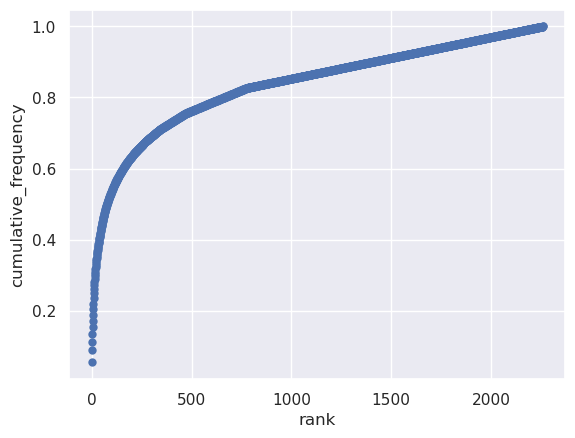

In [113]:
sns.scatterplot(x = atheism_vocabulary["rank"], y = atheism_vocabulary["cumulative_frequency"], linewidth=0);

##### Illustration of Zipf's law <br>

In [114]:
atheism_vocabulary["log_frequency"] = np.log(atheism_vocabulary["frequency"])
atheism_vocabulary['log_rank'] = np.log(atheism_vocabulary["rank"])
#vocabulary

By plotting the log frequency and the log rank we see an almost linear relationship between the tokens.

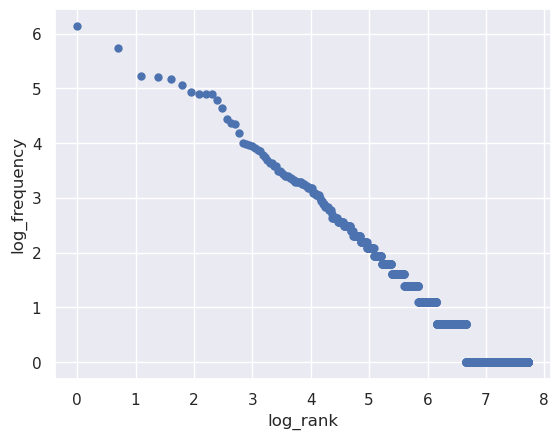

In [115]:
sns.scatterplot(data = atheism_vocabulary, x = "log_rank", y = "log_frequency", linewidth=0);

In [116]:
Na = atheism_vocabulary['frequency'].sum()
atheism_vocabulary['proportion'] = atheism_vocabulary['frequency']/Na
atheism_vocabulary['predicted_proportion'] = (1/atheism_vocabulary['rank']**1)/(np.sum(1/(np.arange(1, Na+1)**1))) # zipfs prediction

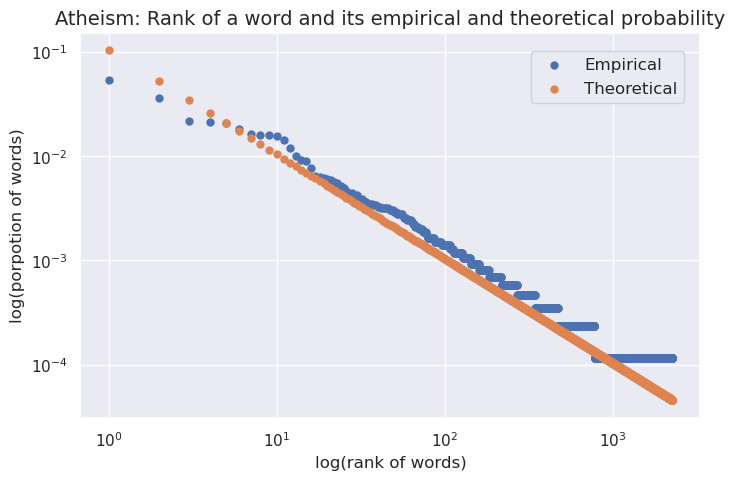

In [117]:
fig_atheism, a = plt.subplots(figsize = (8,5))
a = sns.scatterplot(x=atheism_vocabulary["rank"], y=atheism_vocabulary['proportion'], linewidth=0)
a = sns.scatterplot(x=atheism_vocabulary["rank"], y=atheism_vocabulary['predicted_proportion'], linewidth=0)
a.set(yscale="log", xscale="log")
plt.xlabel("log(rank of words)")
plt.ylabel("log(porpotion of words)")
plt.title("Atheism: Rank of a word and its empirical and theoretical probability", size=14)
fig_atheism.legend(labels=['Empirical', 'Theoretical'], bbox_to_anchor=(.89, .86), fontsize=12)
plt.show(fig_atheism)

## Comparing the datasets
Comment on the difference between the binary class and the multi-class  
mean words per tweet  
most frequent words in each  
how many words occur once twice etc

First looking at the average number of characters and words in each class.

In [118]:
# Average character per tweet
lengths_atheism = [len(tweet) for tweet in train_atheism["tweets"]]
lengths_irony = [len(tweet) for tweet in train_irony["tweets"]]
print("Average character for atheism dataset:", round(np.mean(lengths_atheism), 2))
print("Average character for irony dataset:", round(np.mean(lengths_irony), 2), "\0")
print("On Average a tweet from the atheism dataset is using",  round(np.mean(lengths_atheism)/np.mean(lengths_irony), 2), 
      "times more characters than from the irony dataset.\0")

#Average word per tweet
lengths_atheism = [len(tweet.split()) for tweet in train_atheism["tweets"]]
lengths_irony = [len(tweet.split()) for tweet in train_irony["tweets"]]
print("Average word for the atheism dataset:", round(np.mean(lengths_atheism), 2))
print("Average word for the irony dataset:", round(np.mean(lengths_irony), 2),"\0")
print("On Average a tweet from the atheism dataset is using",  round(np.mean(lengths_atheism)/np.mean(lengths_irony), 2), 
      "times more words than from the the irony dataset.")

Average character for atheism dataset: 107.82
Average character for irony dataset: 79.09  
On Average a tweet from the atheism dataset is using 1.36 times more characters than from the irony dataset. 
Average word for the atheism dataset: 18.2
Average word for the irony dataset: 13.58  
On Average a tweet from the atheism dataset is using 1.34 times more words than from the the irony dataset.


In the evaluated dataset, people twitting about religion (or not being religous) wrote longer tweets than people expressing irony.

In [119]:
# Top n words in each dataset
for n in [5, 10, 20, 50, 100]:
    top_atheism = list(atheism_vocabulary["word"])[0:n]
    top_irony = list(irony_vocabulary["word"])[0:n]
    top_frequency = len([word for word in top_atheism if word in top_irony])/len(top_atheism)
    print(top_frequency*100, "% of the top", n, "words in atheism dataset appear in the top", n ,"of the irony dataset")

40.0 % of the top 5 words in atheism dataset appear in the top 5 of the irony dataset
80.0 % of the top 10 words in atheism dataset appear in the top 10 of the irony dataset
75.0 % of the top 20 words in atheism dataset appear in the top 20 of the irony dataset
68.0 % of the top 50 words in atheism dataset appear in the top 50 of the irony dataset
69.0 % of the top 100 words in atheism dataset appear in the top 100 of the irony dataset


Here we see that most of the top words above top 5 are mostly the same, even when comparing completly different topics. This could mean that the context of the tweet is based on very few words, and the rest are just filler words.

In [120]:
top10_irony = irony_vocabulary.iloc[:10,:2].reset_index(drop=True)
top10_irony

,word,frequency
0,user,1668
1,the,1046
2,to,923
3,a,780
4,i,740
5,and,585
6,is,498
7,in,451
8,you,439
9,of,427


In [121]:
top10_atheism = atheism_vocabulary.iloc[:10,:2].reset_index(drop=True)
top10_atheism

,word,frequency
0,semst,461
1,the,308
2,to,186
3,of,182
4,and,176
5,you,157
6,is,140
7,user,135
8,god,135
9,in,133


As twitter usenames were all changed to 'user' we can see a big difference between user mentions in both datasets. For irony the word 'user' ranks number 1 with a frequency of 1668, and for atheism it ranks 7 with a frequency of 135.

Even with the difference between corpus size, we can still see that use mentions are much higher in the irony dataset.

In [122]:
data_um = {'total_tweets': [len(train_irony), len(train_atheism)],
        'total_words':[len(irony_tokens), len(atheism_tokens)],
        'user_mentions':[top10_irony['frequency'][top10_irony['word'] == 'user'][0],
         top10_atheism['frequency'][top10_atheism['word'] == 'user'][7]]
        }

user_mentions = pd.DataFrame(data_um, index =['irony_train',
                                'atheism_train'
                                ])
  
user_mentions['user_mentions_percentage'] = user_mentions['user_mentions']/user_mentions['total_words'] * 100

user_mentions

,total_tweets,total_words,user_mentions,user_mentions_percentage
irony_train,2762,38428,1668,4.340585
atheism_train,461,8560,135,1.577103


### Differences in balance/inbalance
The irony dataset is mapped as follows:
- 0	not ironic
- 1	ironic

The atheism dataset is mapped as follows:
- 0	none
- 1	against
- 2	favor

In [123]:
irony_train['labels'].value_counts()

1    1445
0    1417
Name: labels, dtype: int64

In [124]:
atheism_train['labels'].value_counts()

1    273
0    105
2     83
Name: labels, dtype: int64

As we can see above, the irony dataset has almost perfect balance, unlike the atheism dataset where we can see a big inbalance between classes.  

And as there are many more tweets against atheism than neutral or in favour, this imbalance can become an issue because the predictive model would be biased towards predicting 'against' and to lesser degree to 'none' than 'favor'.

# 3. Manual Annotation and Inter-Annotator Agreement

Smaller datasets, each consisting of 120 randomly selected tweets from each task’s training set, were provided to do manual annotation and Inter-Annotator Agreement thereof. The chosen task to do annotations was *Irony*. 
Before annotating an agreed upon scheme was discussed based on the research paper “[SemEval-2018 Task 3: Irony Detection in English Tweets](https://www.aclweb.org/anthology/S18-1005.pdf)” provided from the SemEval workshop, describing how each of the original datasets was created and annotated. Here it is stated that all annotations were done using the brat rapid annotation tool, a Web-based Tool for NLP-Assisted Text Annotation, specifically following the report “[Guidelines for Annotating Irony in Social Media Text](https://core.ac.uk/download/pdf/74589284.pdf)”. 
From this, we agreed on some definitions of irony:
> Irony is the use of words to express something other than and especially the opposite of the literal meaning.

Meaning we first and foremost were to annotate a tweet as being ironic, if the tweet was ironic by means of a literal meaning clash or not. <br>
However, as the guide describes there are different forms of irony and an instance can therefore contain another from of irony, where there is no polarity clash, but the tweet still will be found ironic, e.g. situational irony.

Therefore, when investigating the tweets, we were to think about whether the tweet was:
- Ironic by means of a clash: the text expresses an evaluation whose literal polarity is opposite to the intended polarity. <code>1 - irony</code>
- Other type of irony: there is no clash between the literal and the intended evaluation, but the text is still ironic. <code>1 - irony</code>
- Not ironic: the text is not ironic. <code>0 - non_irony</code>

Working independently each group member manually went through the sample and labelled them according to the agreed upon scheme. Next the Inter-annotator agreement (IAA) coefficients were computed using the [nltk.metrics.agreement module](https://www.nltk.org/api/nltk.metrics.html).

In [125]:
MAA

,sabrina,rasmus,ruben,ida,magnus,truth
0,1,1,0,1,1,1
1,0,0,1,0,1,1
2,0,1,0,1,1,1
3,0,0,0,0,0,0
4,0,1,1,1,1,1
...,...,...,...,...,...,...
115,0,1,0,0,1,0
116,0,1,1,0,0,0
117,0,0,1,1,0,1
118,0,0,1,1,1,1


Individual scores.

In [126]:
for name in MAA.columns:
    score = 0
    for i in range(len(MAA[name])):
        if list(MAA[name])[i] == list(MAA["truth"])[i]:
            score += 1
    print(name, score/120)

sabrina 0.675
rasmus 0.7083333333333334
ruben 0.675
ida 0.875
magnus 0.5416666666666666
truth 1.0


In [127]:
rasmus_labels = [("rasmus", i, list(MAA["rasmus"])[i]) for i in range(len(list(MAA["rasmus"])))]
sabrina_labels = [("sabrina", i, list(MAA["sabrina"])[i]) for i in range(len(list(MAA["sabrina"])))]
ruben_labels = [("ruben", i, list(MAA["ruben"])[i]) for i in range(len(list(MAA["ruben"])))]
ida_labels = [("ida", i, list(MAA["ida"])[i]) for i in range(len(list(MAA["ida"])))]
magnus_labels = [("magnus", i, list(MAA["magnus"])[i]) for i in range(len(list(MAA["magnus"])))]
truth_labels = [("truth", i, list(MAA["truth"])[i]) for i in range(len(list(MAA["truth"])))]

ls_w_truth = []
ls_wo_truth = []

for i in range(len(rasmus_labels)):
    ls_w_truth.append(sabrina_labels[i])
    ls_w_truth.append(rasmus_labels[i])
    ls_w_truth.append(ruben_labels[i])
    ls_w_truth.append(ida_labels[i])
    ls_w_truth.append(magnus_labels[i])
    ls_w_truth.append(truth_labels[i])
    ls_wo_truth.append(sabrina_labels[i])
    ls_wo_truth.append(rasmus_labels[i])
    ls_wo_truth.append(ruben_labels[i])
    ls_wo_truth.append(ida_labels[i])
    ls_wo_truth.append(magnus_labels[i])

Confusion matrix for the annotations.

In [128]:
y_true = MAA["truth"]

for name in MAA.columns:
    print(name, "\0", confusion_matrix(y_true, MAA[name]), "\0")

print("[[""non-irony labelled non-irony - non-irony labelled irony""]", "\0", "[ irony labelled non-irony - irony labelled irony]]")

sabrina   [[62  3]
 [36 19]]  
rasmus   [[53 12]
 [23 32]]  
ruben   [[42 23]
 [16 39]]  
ida   [[62  3]
 [12 43]]  
magnus   [[18 47]
 [ 8 47]]  
truth   [[65  0]
 [ 0 55]]  
[[non-irony labelled non-irony - non-irony labelled irony]   [ irony labelled non-irony - irony labelled irony]]


First taking a look at the IAA coefficients when <u>not</u> including the truth labels.

In [129]:
t = AnnotationTask(data = ls_wo_truth)
print("Average observed agreement:", t.avg_Ao())
print("S score:", t.S())
print("Scott's multi-pi score:", t.pi())
print("Cohen's kappa score:", t.kappa())
print("Fleiss' multi-kappa score:", t.multi_kappa())

Average observed agreement: 0.6016666666666667
S score: 0.20333333333333337
Scott's multi-pi score: 0.1941647185757958
Cohen's kappa score: 0.2445540955840891
Fleiss' multi-kappa score: 0.22519991355089689


Now, when including the true labels as an annotator, we get the following IAA coefficients:

In [130]:
t_w_truth = AnnotationTask(data = ls_w_truth)
print("Average observed agreement:", t_w_truth.avg_Ao())
print("S score:", t_w_truth.S())
print("Scott's multi-pi score:", t_w_truth.pi())
print("Cohen's kappa score:", t_w_truth.kappa())
print("Fleiss' multi-kappa score:", t_w_truth.multi_kappa())

Average observed agreement: 0.6327777777777778
S score: 0.26555555555555554
Scott's multi-pi score: 0.25771459319509327
Cohen's kappa score: 0.2922829679933372
Fleiss' multi-kappa score: 0.2770161878372467


It is important to remember that the original annotations are done by humans. They might have been through more training and been taking longer time to do the annotations, but they are not necessarily "true annotations". We therefore include them, as it is an indicator of the diffuculty of carrying out annotation tasks consistently. <br>
<br>
Finding the pair-wise kappa scores, mostly to make a figure for the report and seeing the distribution of agreement.

In [131]:
names = [i for i in MAA.columns]
list_of_labels = [sabrina_labels, rasmus_labels, ruben_labels, ida_labels, magnus_labels, truth_labels]

total_sum = 0
for i, name in enumerate(names):
    print("\0 name:", name)
    current = list_of_labels[i]
    #print(current)
    for idx in range(len(names)):
        if idx != i:
            ls = []
            pair_with_name = names[idx]
            pair_with = list_of_labels[idx]
            for annotation in range(len(current)):
                ls.append(current[annotation])
                ls.append(pair_with[annotation])
            #print(ls)
            t = AnnotationTask(data = ls)
            print(names[idx], t.kappa())
            total_sum += t.kappa()

print("\0Average kappa:", total_sum/30)

  name: sabrina
rasmus 0.5187165775401072
ruben 0.24918389553862905
ida 0.37418513689700117
magnus 0.01880621422730981
truth 0.3137829912023461
  name: rasmus
sabrina 0.5187165775401072
ruben 0.40528634361233473
ida 0.39573459715639814
magnus 0.015444015444015542
truth 0.40340909090909105
  name: ruben
sabrina 0.24918389553862905
rasmus 0.40528634361233473
ida 0.40463065049614094
magnus -0.053227633069082736
truth 0.3518005540166206
  name: ida
sabrina 0.37418513689700117
rasmus 0.39573459715639814
ruben 0.40463065049614094
magnus 0.11678115799803723
truth 0.7450424929178471
  name: magnus
sabrina 0.01880621422730981
rasmus 0.015444015444015542
ruben -0.053227633069082736
ida 0.11678115799803723
truth 0.12466843501326258
  name: truth
sabrina 0.3137829912023461
rasmus 0.40340909090909105
ruben 0.3518005540166206
ida 0.7450424929178471
magnus 0.12466843501326258
 Average kappa: 0.2922829679933372


*(Landis and Koch, Biometrics 1977)*
<div>
<img src="../figures/LandisandKoch.png" width="500"/>
</div>

**Agreement Without Chance Correction**<br>
The group got an **average observed agreement** of 0.60, which according to the rule of thumb given by Landis and Koch-scale is on the edge between being a moderate and substantial level of agreement.
The average observed agreement between the group members can however be due to chance, as the Irony dataset only has two possible labels, causing the probability of getting a label right by chance to be high. <br><br>
$$A_O = \frac{\text{no. matches}}{\text{no. total items}}$$

In the NLTK library we used the function <code>avg_o()</code> which computed the *“average observed agreement across all coders and items.”* <br>
General problems with the observed agreement is the bias in favor of dimensions with a small number of categories. Therefore also the problem of getting figures that are comparable across studies of different dimensions with different number of categories, as it must be adjusted for chance agreement to do so. 


**Chance-corrected Agreement** <br>
The three best-known coefficients, $S$ <I>(Bennett, Alpert, and Goldstein 1954)</I>, $\pi$ <I>(Scott 1955)</I>, and $\kappa$ <I>(Cohen 1960)</I> is in it’s basic form used when measuring agreement between two coders. Yet the NLTK library made it possible for us to use with more than two coders. 

The above mentioned coefficients use the following formula:
$$ S, \pi, \kappa = \frac{\text{observed agreement} - \text{expected agreement}}{1 - \text{expected agreement}}$$

The difference between $S$, $\pi$ and $\kappa$ lies in the assumptions to the calculation of the chance of coder $c_i$ assigning an arbitrary item to category $k$, as follows:
* Coefficient of $S$ is based on the assumption that if coders were operating by chance alone, we would get a uniform distribution.
* Coefficient of $\pi$ is based on the assumption that if coders were operating by chance one, we would get the same distribution of each coder. 
* Coefficient of $\kappa$ is based on the assumption that if coders were operating by chance alone, we would get a separate distribution for each coder.

From: [Inter-Coder Agreement for Computational Linguistics](https://www.aclweb.org/anthology/J08-4004.pdf)

From the NLTK librabry these functions were used to compute the following with the corresponding scores as a result:
* <code>S()</code>: 0.2656 (Bennett, Albert and Goldstein)
* <code>pi()</code>: 0.2577 (Scott; here, multi-pi. Equivalent to K from Siegel and Castellan)
* <code>kappa()</code>: 0.2923 (Cohen. Averages naively over kappas for each coder pair)
* <code>multi-kappa()</code>: 0.2770 (Davies and Fleiss. Averages over observed and expected agreements for each coder pair)

**Inter-annotator agreement problematics**

Common reasons for low intra-annotor agreement scores is:
* ill-defined guidelines
* use of specific priming effects
* insuficient information to make decisions
* different annotator background
* different understanding of the task 

In general Inter-Annotator Agreement gives an indication of how well-defined and reproducible the task is. In this case it shows that the task of detecting irony in writing and especially a somewhat short text as a tweet is difficult even for the human reader. When the group discussed the annotation of the dataset afterwards it was agreed upon that possible context was lacking.
As mentioned earlier all instances of present irony was not necessarily being in the means of a clash, but also other type of irony, making the guidelines possibly too loose and cause of diverging interpretations of when something is ironic or not.

# 4. Automatic Prediction
---
This section is split into two parts, Binary Classification on Irony Dataset, and Multiclass-classification on the Stance Dataset. The muliticlass-classification is further split into two parts, doing classification on a sub-stance (Atheism) and classifying whether a tweet is a specific stance with a model trained on all of the different stances at the same time. 

## Binary Classification on Irony Dataset

### Tokenizing data

Using the <code>tokenize_ideal</code> function from earlier to tokenize the data and converting it to be an useable datatype.

In [132]:
def tokenizer(file_name):
    with open(file_name, 'r', encoding="utf8") as f:
        data = f.read().split("\n")
        corpus = []
        for line in data:
            ls = tokenize_ideal(line)
            corpus.append(ls[0])
        
        if corpus[-1] == "":
            return corpus[:-1]
        
        return corpus

train_corpus = tokenizer("./datasets/irony/train_text.txt")
test_corpus = tokenizer("./datasets/irony/test_text.txt")
validation_corpus = tokenizer("./datasets/irony/val_text.txt")

### Loading the train labels

In [133]:
def y_data(location):
    y_train = []
    for i in open(location):
        y_train.append(int(i.replace("\n","")))
    
    return y_train

y_train = y_data("./datasets/irony/train_labels.txt")
y_test = y_data("./datasets/irony/test_labels.txt")
y_val = y_data("./datasets/irony/val_labels.txt")

In [134]:
Counter(y_train)

Counter({1: 1445, 0: 1417})

Balanced data, thus we try and optimize the accuracy score.

### Creating pipeline

Creating the pipeline, to make it easier to preprocess, train/fit and predict on data. Having it be a function to reduce duplicate code.

In [135]:
def model_pipeline(model):
    return Pipeline([('vect', CountVectorizer(preprocessor = lambda x: x, tokenizer = lambda x: x,token_pattern=None)),
                                             ('tfidf', TfidfTransformer()), 
                                             ('clf', model)
                                             ])

### Baseline model

Training our baseline model on our tokenized training corpus.

In [136]:
LR = model_pipeline(SGDClassifier(loss='log_loss', random_state=42)).fit(train_corpus, y_train);

In [137]:
predicted = LR.predict(validation_corpus)
accuracy_score(predicted, y_val)

0.556020942408377

An accuracy_score of 0.556 is not the best.

### Classification models different models

Training different classifying models without any special tuning to see which is the best in its simplest form.

In [138]:
KNN = model_pipeline(KNeighborsClassifier()).fit(train_corpus, y_train)
DTC = model_pipeline(DecisionTreeClassifier(random_state=42)).fit(train_corpus, y_train)
RFC = model_pipeline(RandomForestClassifier(random_state=42)).fit(train_corpus, y_train)
SV  = model_pipeline(SVC(random_state=42)).fit(train_corpus, y_train)
NB  = model_pipeline(MultinomialNB()).fit(train_corpus,y_train)

#### Comparison

In [139]:
modelsc = [LR, KNN, DTC, RFC, SV, NB]
d = ["LogisticRegression",
     "KNearestNeighbor",
     "DecisionTreeClassifier",
     "RandomForestClassifier",
     "SupportVectorClassifier",
     "NaiveBayes"]

Finding the different metrics that are useable and give insight into how good the specific model is. Here we mainly look at accuracy_score and f1 score since recall and precision can be "gamed" but they can not both be gamed at the same time, thus using the f1 score gives credible insight into both recall and precision and thus an overall score for the performance of the model.

Accuracy is the proportion of elements classified correctly:

$$Accuracy = \frac{\text{sum of diagonal}}{\text{total sum}}$$

Accuracy can be very misleading in unbalanced datasets.

Precision: Out of the examples we **predicted to be** in a certain class, how many of them are correct?
<br><br>
$$
Precision=\frac{\text{single diagonal element}}{\text{sum of a single column} }
$$


Recall: Out of the examples **that actually belong** to a certain class, how many of them did we find?
<br><br>
$$
Recall = \frac{\text{single diagonal element}}{\text{sum of a single row} }
$$

F-score: Harmonic mean of Precision and Recall

$$
F_{score} = 2 \cdot \frac{P\cdot R}{P+R}
$$

In [140]:
for idx, model in enumerate(modelsc):
    name = d[idx]
    predict = model.predict(validation_corpus)
    print(str(name) + ": ")
    print("     - accuracy score:\t   {}"  .format(accuracy_score( y_val, predict)))
    print("     - recall score: \t   {}"   .format(recall_score(   y_val, predict)))
    print("     - precision score:\t   {}" .format(precision_score(y_val, predict)))
    print("     - f1 score:\t   {}"        .format(f1_score(       y_val, predict)))
    print()

LogisticRegression: 
     - accuracy score:	   0.556020942408377
     - recall score: 	   0.6710526315789473
     - precision score:	   0.5275862068965518
     - f1 score:	   0.5907335907335908

KNearestNeighbor: 
     - accuracy score:	   0.5267015706806283
     - recall score: 	   0.5504385964912281
     - precision score:	   0.5040160642570282
     - f1 score:	   0.5262054507337526

DecisionTreeClassifier: 
     - accuracy score:	   0.5403141361256545
     - recall score: 	   0.5482456140350878
     - precision score:	   0.5175983436853002
     - f1 score:	   0.5324813631522897

RandomForestClassifier: 
     - accuracy score:	   0.574869109947644
     - recall score: 	   0.543859649122807
     - precision score:	   0.5560538116591929
     - f1 score:	   0.5498891352549888

SupportVectorClassifier: 
     - accuracy score:	   0.5539267015706806
     - recall score: 	   0.6271929824561403
     - precision score:	   0.5276752767527675
     - f1 score:	   0.5731462925851704

NaiveBayes: 

Now doing cross-validation on the validation dataset and taking the mean of the cross-validation-scores, we can find the overall best models for our task.

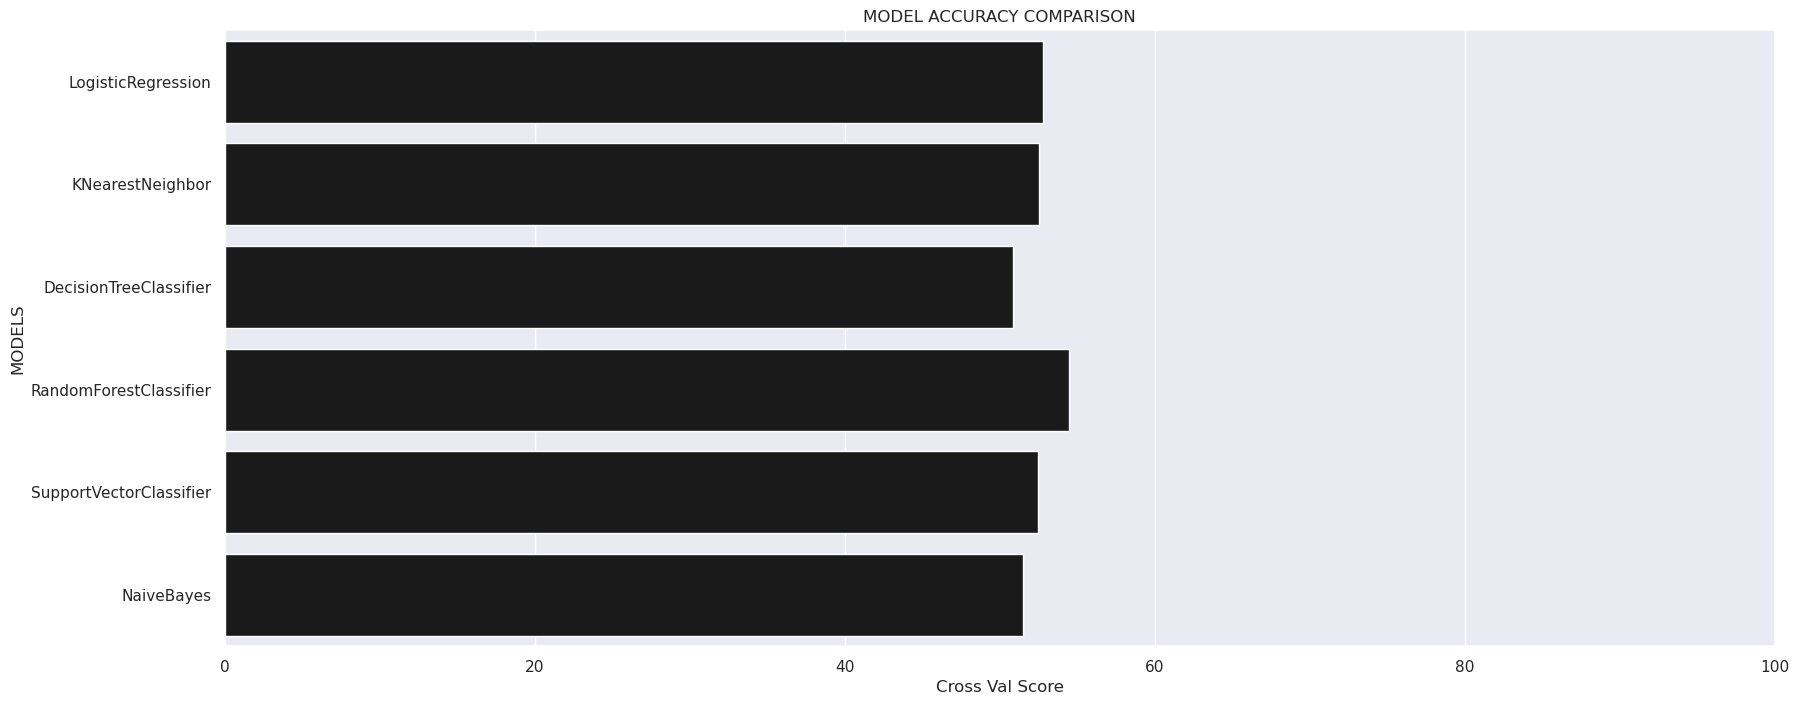

In [141]:
r = pd.DataFrame(columns=["MODELS","R2CV"])
for i, model in enumerate(modelsc):
    name = d[i]
    R2CV = cross_val_score(model,validation_corpus,y_val,cv=2).mean()
    result = pd.DataFrame([[name,R2CV*100]],columns=["MODELS","R2CV"])
    r = r.append(result)

figure = plt.figure(figsize=(20,8))
sns.barplot(x="R2CV",y="MODELS",data=r,color="k")
plt.xlabel("Cross Val Score")
plt.ylabel("MODELS")
plt.xlim(0,100)
plt.title("MODEL ACCURACY COMPARISON")
plt.show()

Here we see that none of our models perform particularly well, though we still have some models performing better than others.

#### Tuning the best models

Now we try to find the best possible combination of parameters to achieve the highest F-score.

In [142]:
scores = {}
accuracyscore = {}
recallscore = {}
precisionscore = {}
fscore = {}

Starting with the Random Forest Classifier

##### Random Forest Classifier

Initializing a simple RFC model (no parameters), that can be tweaked

In [143]:
RFC_noob = model_pipeline(RandomForestClassifier(random_state=42))

Testing all possible combinations of chosen parameters and finding the F-score (very time consuming)

In [144]:
parameters = {"clf__n_estimators": [100, 500, 1000, 2000],
             "clf__max_depth": [3, 6, 12, 24, 48],
             "clf__criterion": ["gini", "entropy"],
             }

In [145]:
gs_clf = GridSearchCV(RFC_noob, parameters, cv=2, n_jobs=-1).fit(train_corpus, y_train)

In [146]:
scores["RFC"] = gs_clf.best_score_
scores["RFC"]

0.5670859538784068

In [147]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__criterion: 'gini'
clf__max_depth: 12
clf__n_estimators: 100


In [148]:
RFC_tuned = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
                     ), ('tfidf', TfidfTransformer()
                     ), ('clf', RandomForestClassifier(random_state=42, 
                                                       criterion = 'gini', 
                                                       max_depth= 12, 
                                                       n_estimators= 100))]).fit(train_corpus, y_train);

In [149]:
predict = RFC_tuned.predict(validation_corpus)
accuracyscore["RandomForestClassifier"] = accuracy_score(y_val ,predict) 
recallscore["RandomForestCl*assifier"] = recall_score(y_val, predict)
precisionscore["RandomForestClassifier"] = precision_score(y_val, predict)
fscore["RandomForestClassifier"] = f1_score(y_val, predict)

##### Support vector

Initializing a simple Support Vector model (no parameters), that can be tweaked

In [150]:
SV_noob = model_pipeline(SVC(random_state=42))

Testing all possible combinations of chosen parameters and finding the F-score (very time consuming)

In [151]:
parameters = {"clf__C": [1,3,9,27],
              "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
              "clf__degree": [1,3,9,27],
             }

In [152]:
gs_clf = GridSearchCV(SV_noob, parameters, cv=2, n_jobs=-1).fit(train_corpus, y_train)

In [153]:
scores["SV"] = gs_clf.best_score_
scores["SV"]

0.5681341719077568

In [154]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__C: 1
clf__degree: 1
clf__kernel: 'rbf'


In [155]:
SV_tuned = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None )
                     ), ('tfidf', TfidfTransformer()
                     ), ('clf', SVC(random_state=42, 
                                    C = 1, 
                                    degree= 1,
                                    kernel="rbf"))]).fit(train_corpus, y_train);

In [156]:
predict = SV_tuned.predict(validation_corpus)
accuracyscore["SupportVector"] = accuracy_score(y_val ,predict) 
recallscore["SupportVector"] = recall_score(y_val, predict)
precisionscore["SupportVector"] = precision_score(y_val, predict)
fscore["SupportVector"] = f1_score(y_val, predict)

##### Logistic Regression

In [157]:
LR_noob = model_pipeline(SGDClassifier(loss='log_loss', random_state=42))

In [158]:
parameters = {"clf__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
             "clf__penalty": ["l2", "l1", "elasticnet"],}

In [159]:
gs_clf = GridSearchCV(LR_noob, parameters, cv=2, n_jobs=-1).fit(train_corpus, y_train)

In [160]:
scores["LR"] = gs_clf.best_score_
scores["LR"]

0.562543675751223

In [161]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0003
clf__penalty: 'l2'


In [162]:
LR_tuned = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None )
                     ), ('tfidf', TfidfTransformer()
                     ), ('clf', SGDClassifier(loss="log", 
                                    random_state=42,
                                    alpha=0.0003, 
                                    penalty= "l2"))]).fit(train_corpus, y_train);

In [163]:
predict = LR_tuned.predict(validation_corpus)
accuracyscore["LogisticRegression"] = accuracy_score(y_val ,predict) 
recallscore["LogisticRegression"] = recall_score(y_val, predict)
precisionscore["LogisticRegression"] = precision_score(y_val, predict)
fscore["LogisticRegression"]= f1_score(y_val, predict)

##### Final model on the basis of the validation data

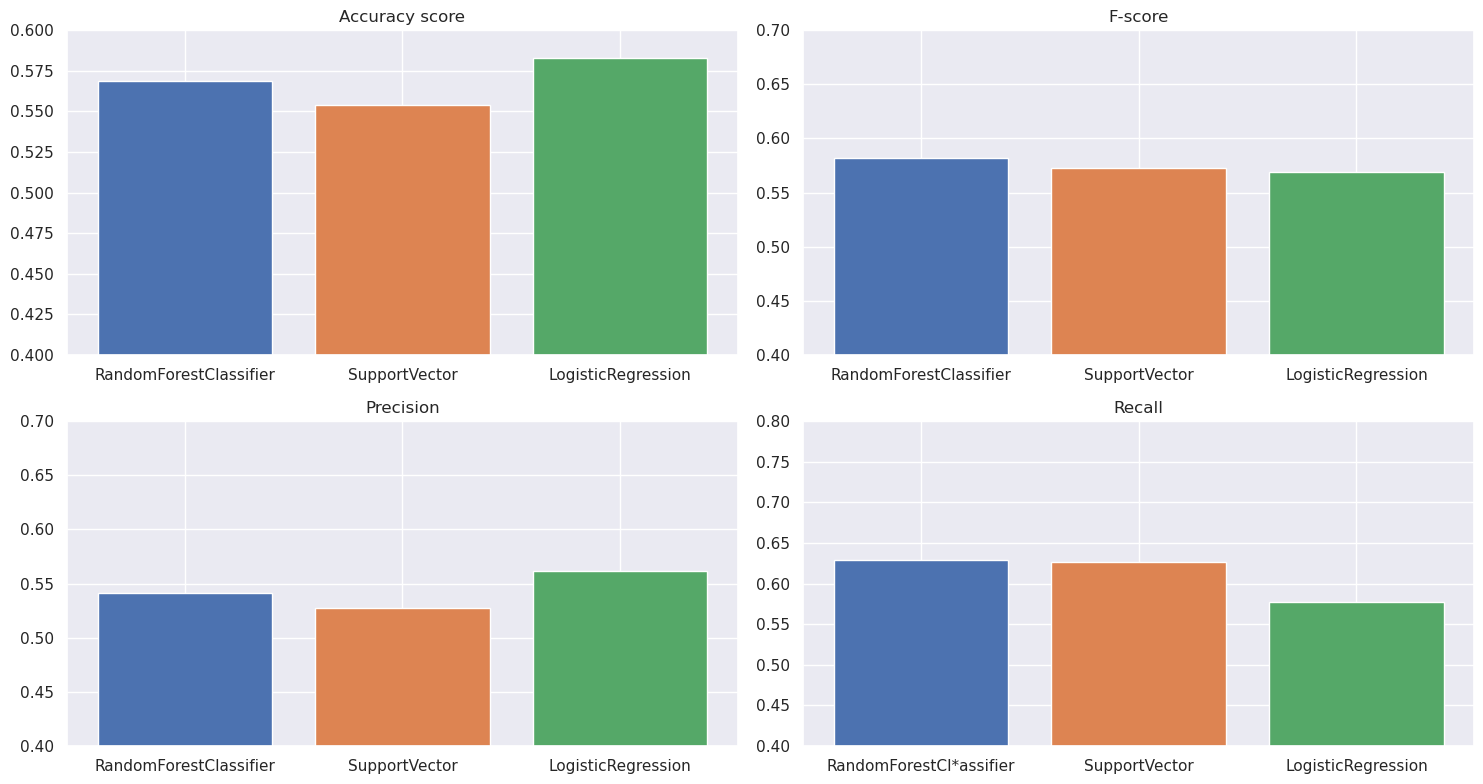

In [164]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
ax[0,0].set_title("Accuracy score")
ax[0,1].set_title("F-score")
ax[1,0].set_title("Precision")
ax[1,1].set_title("Recall")

for i in accuracyscore.items():
    ax[0,0].bar(i[0], i[1])
    ax[0,0].set_ylim([0.4,0.6])

for i in fscore.items():
    ax[0,1].bar(i[0], i[1])
    ax[0,1].set_ylim([0.4,0.7])
    
for i in precisionscore.items():
    ax[1,0].bar(i[0], i[1])
    ax[1,0].set_ylim([0.4,0.7])
    
for i in recallscore.items():
    ax[1,1].bar(i[0], i[1])
    ax[1,1].set_ylim([0.4,0.8])

plt.tight_layout()

We see that the models that we have tuned to have the highest accuracy score are all equally bad at classifying whether a given sentence is ironic.

It is logical that our model is really bad at classifying text-based irony, since the group members are also very poor at classifying irony. Thus we can not expect the model to outperform us massively, since it lacks world knowledge and general experience and the emotional aspect of understanding the users intentions. Perhabs combining an intention model and an irony model could increase the performance of the irony model.

Final model is LogisticRegression, since it has an higher accuracy score.

##### Final model on test data metrics

In [165]:
model = RFC_tuned
predict = model.predict(test_corpus)
print("Logistic Regression" + ": ")
print("     - accuracy score:\t   {}"  .format(accuracy_score( y_test, predict)))
print("     - recall score: \t   {}"   .format(recall_score(   y_test, predict)))
print("     - precision score:\t   {}" .format(precision_score(y_test, predict)))
print("     - f1 score:\t   {}"        .format(f1_score(       y_test, predict)))
print()

Logistic Regression: 
     - accuracy score:	   0.5535714285714286
     - recall score: 	   0.6688102893890675
     - precision score:	   0.45714285714285713
     - f1 score:	   0.5430809399477806



## Multi-Classification on Stance Dataset

First Multi-classification, mapping all the different stances to a 3x5 map taking values from 0-14 and classifying on the basis of these 15 different labels.

### Creating the neccesery dataframes

In [166]:
hillary_train  = pd.concat([train_hillary,  train_hillary_labels ], axis=1)
abortion_train = pd.concat([train_abortion, train_abortion_labels], axis=1)
atheism_train  = pd.concat([train_atheism,  train_atheism_labels ], axis=1)
climate_train  = pd.concat([train_climate,  train_climate_labels ], axis=1)
feminist_train = pd.concat([train_feminist, train_feminist_labels], axis=1)

abortion_train["labels"] += 3
atheism_train["labels"]  += 6
climate_train["labels"]  += 9
feminist_train["labels"] += 12

In [167]:
hillary_val  = pd.concat([validation_hillary,  validation_hillary_labels ], axis=1)
abortion_val = pd.concat([validation_abortion, validation_abortion_labels], axis=1)
atheism_val  = pd.concat([validation_atheism,  validation_atheism_labels ], axis=1)
climate_val  = pd.concat([validation_climate,  validation_climate_labels ], axis=1)
feminist_val = pd.concat([validation_feminist, validation_feminist_labels], axis=1)

abortion_val["labels"] += 3
atheism_val["labels"]  += 6
climate_val["labels"]  += 9
feminist_val["labels"] += 12

In [168]:
hillary_test  = pd.concat([test_hillary,  test_hillary_labels ], axis=1)
abortion_test = pd.concat([test_abortion, test_abortion_labels], axis=1)
atheism_test  = pd.concat([test_atheism,  test_atheism_labels ], axis=1)
climate_test  = pd.concat([test_climate,  test_climate_labels ], axis=1)
feminist_test = pd.concat([test_feminist, test_feminist_labels], axis=1)

abortion_test["labels"] += 3
atheism_test["labels"]  += 6
climate_test["labels"]  += 9
feminist_test["labels"] += 12

In [169]:
#mapping = {}
#mapping[0]  = "none hillary"
#mapping[1]  = "against hillary"
#mapping[2]  = "favor hillary"
#mapping[3]  = "none abortion"
#mapping[4]  = "against abortion"
#mapping[5]  = "favor abortion"
#mapping[6]  = "none atheism"
#mapping[7]  = "against atheism"
#mapping[8]  = "favor atheism"
#mapping[9]  = "none climate"
#mapping[10] = "against climate"
#mapping[11] = "favor climate"
#mapping[12] = "none feminist"
#mapping[13] = "against feminist"
#mapping[14] = "favor feminist"

In [170]:
combined_train = pd.read_csv(PATHS["combined_stance"].format("combined_train.csv"))
combined_train = combined_train.drop('Unnamed: 0', 1)

combined_val = pd.read_csv(PATHS["combined_stance"].format("combined_val.csv"))
combined_val = combined_val.drop('Unnamed: 0', 1)

combined_test = pd.read_csv(PATHS["combined_stance"].format("combined_test.csv"))
combined_test = combined_test.drop('Unnamed: 0', 1)

### Tokenizing our training and validation tweets

In [171]:
copy_train = combined_train
for idx, i in enumerate(copy_train["tweets"]):
    x = tokenize_ideal(i)
    combined_train.loc[idx, ["tweets"]] = x[0]

copy_val = combined_val
for idx, i in enumerate(copy_val["tweets"]):
    x = tokenize_ideal(i)
    combined_val.loc[idx, ["tweets"]] = x[0]

copy_test = combined_test
for idx, i in enumerate(copy_test["tweets"]):
    x = tokenize_ideal(i)
    combined_test.loc[idx, ["tweets"]] = x[0]
    

combined_val   = combined_val[combined_val['labels'].notna()]
combined_train = combined_train[combined_train["labels"].notna()]
combined_test  = combined_test[combined_test["labels"].notna()]

In [172]:
combined_train["labels"].value_counts()

1     354
4     319
13    295
7     273
11    191
14    189
0     160
3     159
9     151
12    113
5     109
2     106
6     105
8      83
10     13
Name: labels, dtype: int64

Here we see that the data is not balanced.

### Baseline model

In [173]:
LR_multi = model_pipeline(SGDClassifier(loss='log_loss', random_state=42)).fit(combined_train["tweets"], combined_train["labels"]);

In [174]:
predicted = LR_multi.predict(combined_val["tweets"])
accuracy_score(predicted, combined_val["labels"])

0.25510204081632654

### Classification models different models

Training different classifying models without any special tuning to see which is the best in its simplest form.

In [175]:
KNN_multi = model_pipeline(KNeighborsClassifier()).fit(combined_train["tweets"], combined_train["labels"])
DTC_multi = model_pipeline(DecisionTreeClassifier(random_state=42)).fit(combined_train["tweets"], combined_train["labels"])
RFC_multi = model_pipeline(RandomForestClassifier(random_state=42)).fit(combined_train["tweets"], combined_train["labels"])
SV_multi  = model_pipeline(SVC(random_state=42)).fit(combined_train["tweets"], combined_train["labels"])
NB_multi  = model_pipeline(MultinomialNB()).fit(combined_train["tweets"],combined_train["labels"])

In [176]:
modelsc = [LR_multi, KNN_multi, DTC_multi, RFC_multi, SV_multi, NB_multi]
d = ["LogisticRegression",
     "KNearestNeighbor",
     "DecisionTreeClassifier",
     "RandomForestClassifier",
     "SupportVectorClassifier",
     "NaiveBayes"]

Here the precision score will be flawed since our models does not predict all labels in the dataset, i.e the NaiveBayes only predicts 5 out of the 15 different labels in our data, which makes calculating the precision score for these non-predicted labels not possible, since they have not been predicted. This is also the reason that warnings is being returned.

In [177]:
ls = list(range(0,15))
for idx, model in enumerate(modelsc):
    name = d[idx]
    predict = model.predict(combined_val["tweets"])
    uniq, counts = np.unique(predict, return_counts=True)
    print(str(name) + ": ")
    temp = [item for item in ls if item not in uniq]
    print("     - classes not predicted by model: \t {}".format(temp))
    print("     - accuracy score:\t   {}"  .format(accuracy_score( combined_val["labels"],predict)))
    print("     - recall score: \t   {}"   .format(recall_score(   combined_val["labels"], predict, average='macro')))
    print("     - precision score:\t   {}" .format(precision_score(combined_val["labels"], predict, average='macro')))
    print("     - f1 score:\t   {}"        .format(f1_score(       combined_val["labels"], predict, average='macro')))
    print()

LogisticRegression: 
     - classes not predicted by model: 	 [5, 6, 8, 10]
     - accuracy score:	   0.25510204081632654
     - recall score: 	   0.1701842959907476
     - precision score:	   0.21468038160547329
     - f1 score:	   0.1503871642522902

KNearestNeighbor: 
     - classes not predicted by model: 	 [10]
     - accuracy score:	   0.21428571428571427
     - recall score: 	   0.1561443335636884
     - precision score:	   0.15882094124199392
     - f1 score:	   0.1458966873055521

DecisionTreeClassifier: 
     - classes not predicted by model: 	 [10]
     - accuracy score:	   0.18027210884353742
     - recall score: 	   0.14286186439886628
     - precision score:	   0.13871558590856836
     - f1 score:	   0.13950600987034906

RandomForestClassifier: 
     - classes not predicted by model: 	 [6, 8, 10, 12]
     - accuracy score:	   0.23809523809523808
     - recall score: 	   0.15151192893128376
     - precision score:	   0.2267274327352735
     - f1 score:	   0.134505798506462

In our validation data, we have a label that is only occuring twice in our data, which means that we can not perform any proper cross-validation scores on it, as we simply do not have enough data to support any conclusions. This is also the reason that a lot of our classifiers is ignoring these classes with few members, because we train on data that does not have many members of that class.

In [178]:
combined_val["labels"].value_counts()

1     39
4     36
13    33
7     31
11    21
14    21
0     18
3     18
9     17
12    13
2     12
5     12
6     12
8      9
10     2
Name: labels, dtype: int64

This cross validation is thus flawed since a lot of our models is ignoring a lot of the classes in our data, such as the NaiveBayes is ignoring more than half of the classes in the data. This makes it a very bad model for classifying stance, but in the cross validation it, at first glance, looks to have a very high score, which is very misleading.

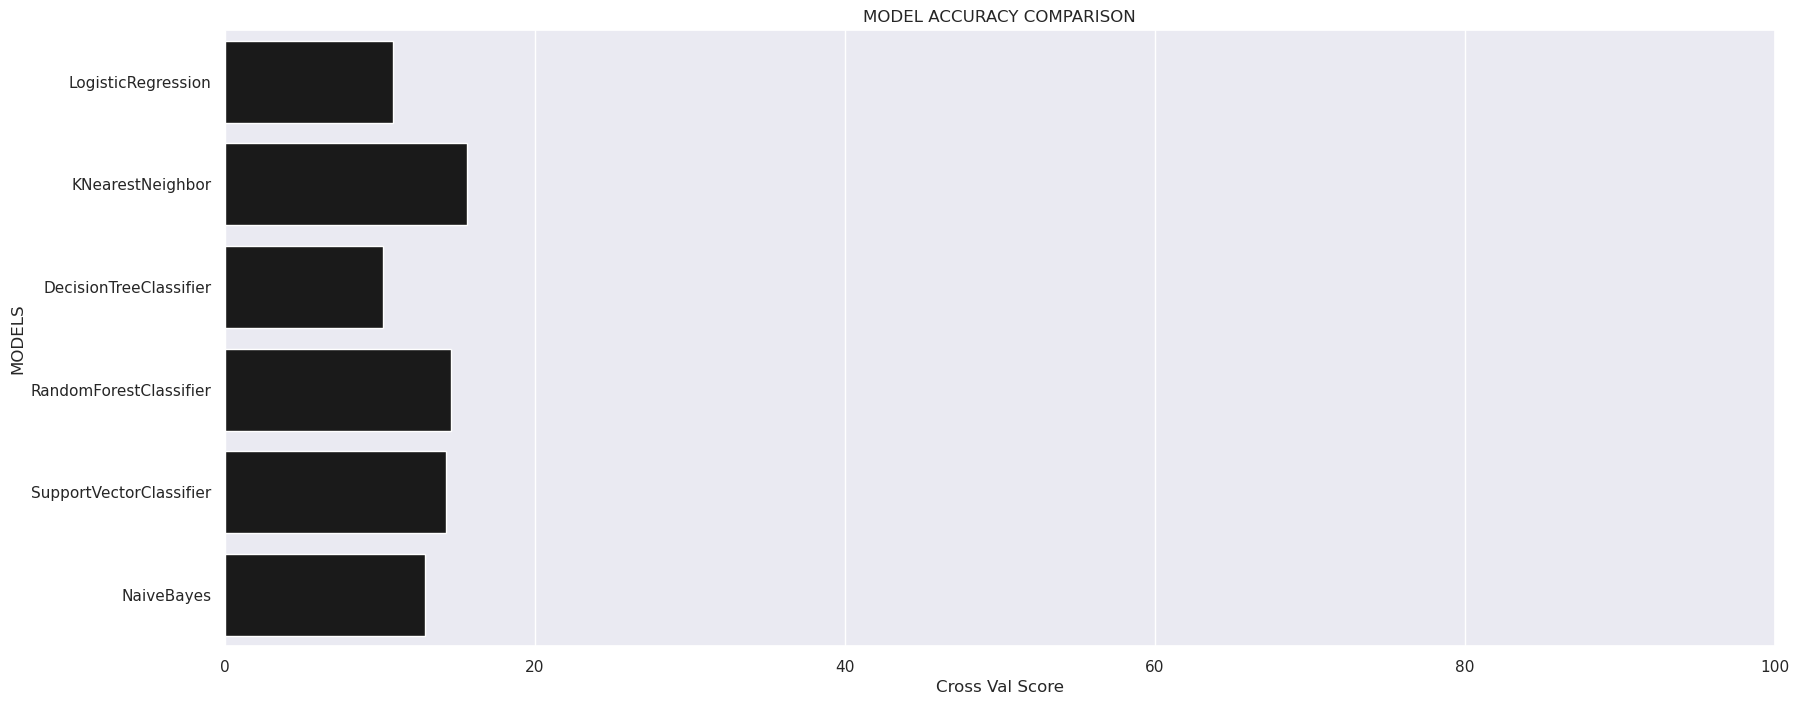

In [179]:
r = pd.DataFrame(columns=["MODELS","R2CV"])
for i, model in enumerate(modelsc):
    name = d[i]
    R2CV = cross_val_score(model, combined_val["tweets"], combined_val["labels"], cv=2).mean()
    result = pd.DataFrame([[name,R2CV*100]], columns=["MODELS","R2CV"])
    r = r.append(result)

figure = plt.figure(figsize=(20, 8))
sns.barplot(x="R2CV", y="MODELS", data=r, color="k")
plt.xlabel("Cross Val Score")
plt.ylabel("MODELS")
plt.xlim(0, 100)
plt.title("MODEL ACCURACY COMPARISON")
plt.show()

#### Tuning the best models

We then decide to try and optimize the models that actually predict most of the classes in our dataset. 

Now we try to find the best possible combination of parameters to achieve the highest F-score.

In [180]:
scores = {}
accuracyscore = {}
recallscore = {}
precisionscore = {}
fscore = {}

##### Logistical Regression

In [181]:
LR_noob_multi = model_pipeline(SGDClassifier(loss='log_loss', random_state=42))

In [182]:
parameters = {"clf__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
              "clf__penalty": ["l2", "l1", "elasticnet"],
             }

In [183]:
gs_clf = GridSearchCV(LR_noob_multi, parameters, cv=2, n_jobs=-1, scoring="recall_macro").fit(combined_train["tweets"], combined_train["labels"]);

In [184]:
scores["LR"] = gs_clf.best_score_
scores["LR"]

0.1673263961829901

In [185]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0001
clf__penalty: 'l1'


In [186]:
LR_tuned_multi = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None )
                     ), ('tfidf', TfidfTransformer()
                     ), ('clf', SGDClassifier(loss="log",
                                    random_state=42,
                                    alpha=0.0001, 
                                    penalty= "l1"))]).fit(combined_train["tweets"], combined_train["labels"]);

In [187]:
predict = LR_tuned_multi.predict(combined_val["tweets"])
ls = list(range(0,15))
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("classes not predicted by model: \t {}".format(temp))
accuracyscore["LogisticRegression"]  = accuracy_score( combined_val["labels"] , predict) 
recallscore["LogisticRegression"]    = recall_score(   combined_val["labels"],  predict, average="macro")
precisionscore["LogisticRegression"] = precision_score(combined_val["labels"],  predict, average="macro")
fscore["LogisticRegression"]         = f1_score(       combined_val["labels"],  predict, average="macro")

classes not predicted by model: 	 [6, 8, 10]


##### Random Forest Classifier

In [188]:
RFC_noob_multi = model_pipeline(RandomForestClassifier(random_state=42))

In [189]:
parameters = {"clf__n_estimators": [100, 500, 1000, 2000],
             "clf__max_depth": [3, 6, 12, 24, 48],
             "clf__criterion": ["gini", "entropy"],
             }

In [190]:
gs_clf = GridSearchCV(RFC_noob_multi, parameters, cv=2, n_jobs=-1, scoring="recall_macro").fit(combined_train["tweets"], combined_train["labels"]);

In [191]:
scores["RFC"] = gs_clf.best_score_
scores["RFC"]

0.15938613573087884

In [192]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__criterion: 'gini'
clf__max_depth: 48
clf__n_estimators: 500


In [193]:
RFC_tuned_multi = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None)
                         ), ('tfidf', TfidfTransformer()
                         ), ('clf', RandomForestClassifier(random_state=42, 
                                                       criterion = 'gini', 
                                                       max_depth= 48, 
                                                       n_estimators= 500))]).fit(combined_train["tweets"], combined_train["labels"]);

In [194]:
predict = RFC_tuned_multi.predict(combined_val["tweets"])
ls = list(range(0,15))
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("classes not predicted by model: {}".format(temp))
accuracyscore["RandomForestClassifier"] = accuracy_score(combined_val["labels"], predict) 
recallscore["RandomForestClassifier"] = recall_score(combined_val["labels"], predict, average="macro")
precisionscore["RandomForestClassifier"] = precision_score(combined_val["labels"], predict, average="macro")
fscore["RandomForestClassifier"] = f1_score(combined_val["labels"], predict, average="macro")

classes not predicted by model: [6, 8, 10, 12]


##### KNearestNeighbor

In [195]:
KNN_noob_multi = model_pipeline(KNeighborsClassifier())

In [196]:
parameters = {"clf__n_neighbors": [1,3,9,27,60,120],
             "clf__weights": ["uniform", "distance"],
             "clf__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
             }

In [197]:
gs_clf = GridSearchCV(KNN_noob_multi, parameters, cv=2, n_jobs=-1, scoring="recall_macro").fit(combined_train["tweets"], combined_train["labels"]);

/home/sabrina/miniconda3/envs/uni/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/sabrina/miniconda3/envs/uni/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 

In [198]:
scores["KNN"] = gs_clf.best_score_
scores["KNN"]

0.15393222858711716

In [199]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__algorithm: 'auto'
clf__n_neighbors: 9
clf__weights: 'distance'


In [200]:
KNN_tuned_multi = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None)
                         ), ('tfidf', TfidfTransformer()
                         ), ('clf', KNeighborsClassifier(algorithm= 'auto', 
                                                         n_neighbors=9,
                                                         weights="distance"))]).fit(combined_train["tweets"],combined_train["labels"])

In [201]:
predict = KNN_tuned_multi.predict(combined_val["tweets"])
ls = list(range(0,15))
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("classes not predicted by model: {}".format(temp))
accuracyscore["KNN"]  = accuracy_score( combined_val["labels"] , predict) 
recallscore["KNN"]    = recall_score(   combined_val["labels"],  predict, average="macro")
precisionscore["KNN"] = precision_score(combined_val["labels"],  predict, average="macro")
fscore["KNN"]         = f1_score(       combined_val["labels"],  predict, average="macro")

classes not predicted by model: [10]


##### Final model

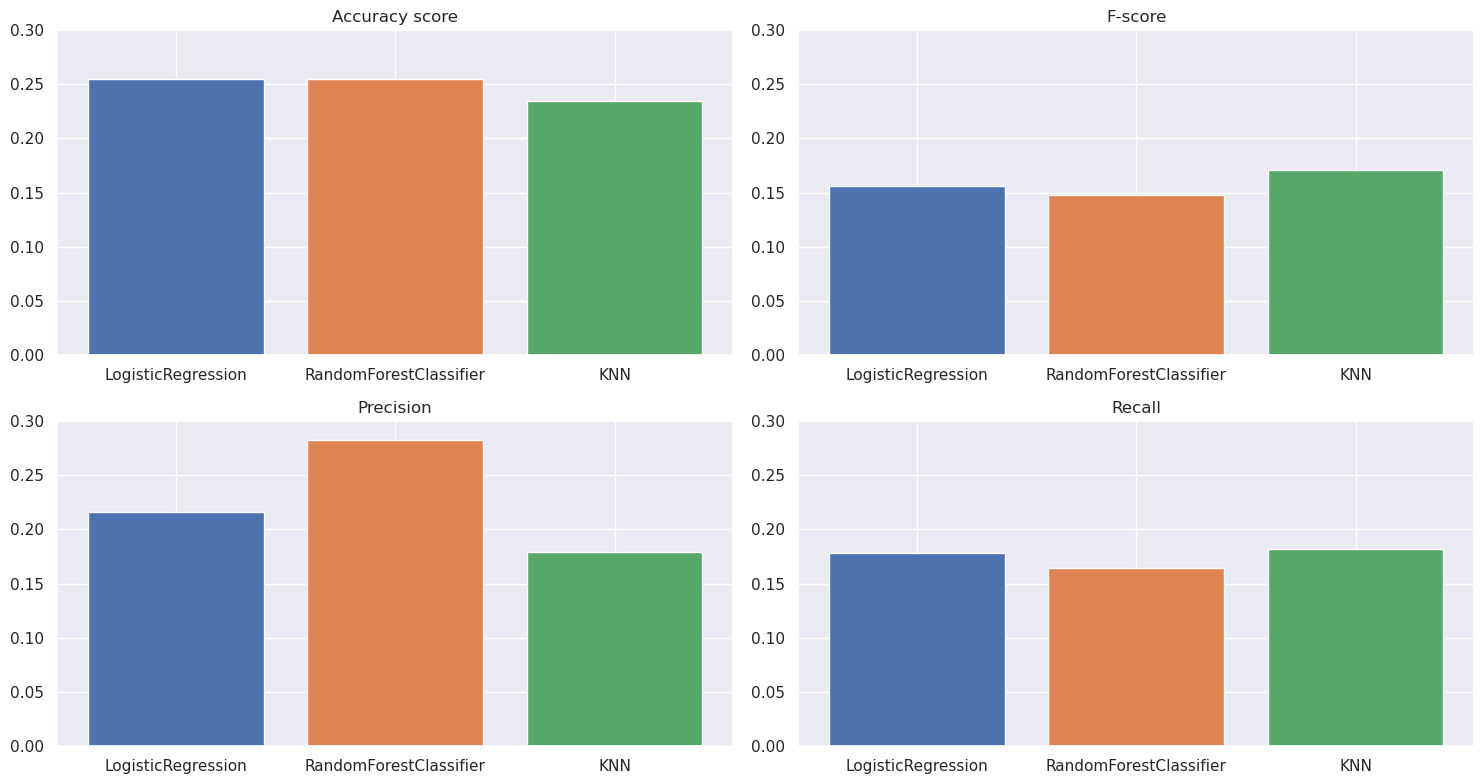

In [202]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
ax[0,0].set_title("Accuracy score")
ax[0,1].set_title("F-score")
ax[1,0].set_title("Precision")
ax[1,1].set_title("Recall")

for i in accuracyscore.items():
    ax[0,0].bar(i[0], i[1])
    ax[0,0].set_ylim([0,0.3])

for i in fscore.items():
    ax[0,1].bar(i[0], i[1])
    ax[0,1].set_ylim([0,0.3])
    
for i in precisionscore.items():
    ax[1,0].bar(i[0], i[1])
    ax[1,0].set_ylim([0,0.3])
    
for i in recallscore.items():
    ax[1,1].bar(i[0], i[1])
    ax[1,1].set_ylim([0,0.3])

plt.tight_layout()

Here we see that the KNN is the best model for our multiclass 3x5 stance mapping, since it only excludes one classification out of the total 15. The accuracy of the KNN is surprisingly high, given the difficulty of the task with this many different classes. Also if one were to randomnly guess (uniformly) what the class was, the probability of getting one correct would be $\frac{1}{15}$ which our models are a lot better than. Meaning our models, even though  very bad, are actually better than random.

Final model: KNN

##### Final model on test data metrics

In [203]:
model = KNN_tuned_multi
predict = model.predict(combined_test["tweets"])
print("KNN" + ": ")
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("     - classes not predicted by model: \t {}".format(temp))
print("     - accuracy score:\t   {}"  .format(accuracy_score( combined_test["labels"], predict)))
print("     - recall score: \t   {}"   .format(recall_score(   combined_test["labels"], predict,  average="macro")))
print("     - precision score:\t   {}" .format(precision_score(combined_test["labels"], predict,  average="macro")))
print("     - f1 score:\t   {}"        .format(f1_score(       combined_test["labels"], predict,  average="macro")))
print()

KNN: 
     - classes not predicted by model: 	 []
     - accuracy score:	   0.21857485988791034
     - recall score: 	   0.1293985722138177
     - precision score:	   0.1290124308772997
     - f1 score:	   0.12514616152456073



#### Checking what subjects test data it performs well on

By only predicting one of the validation datasets using the multiclass 3x5 mapping, we can test what classes it performs well and poorly on.

Here we can not look at the precision and the recall scores, since it will take into account all of the different classes that we are not trying to predict.

In [204]:
ls = [hillary_val, abortion_val, atheism_val, climate_val, feminist_val]
d = ["hillary", "abortion", "atheism", "climate", "feminist"]
for idx, data in enumerate(ls):
    name = d[idx]
    predicted = model.predict(data["tweets"])
    print(str(name) + ": ")
    print("     - accuracy score:\t   {}"  .format(accuracy_score(data["labels"],predicted)))
    print()

hillary: 
     - accuracy score:	   0.34782608695652173

abortion: 
     - accuracy score:	   0.13636363636363635

atheism: 
     - accuracy score:	   0.21153846153846154

climate: 
     - accuracy score:	   0.1

feminist: 
     - accuracy score:	   0.2537313432835821



Here we see that the model varies a lot on the different subject stances.

## Multi-classification on a single stance subject (Atheism)

### Necessary Datasets

In [205]:
atheism_train = pd.concat([train_atheism, train_atheism_labels], axis=1)
atheism_val = pd.concat([validation_atheism, validation_atheism_labels], axis=1)
atheism_test = pd.concat([test_atheism, test_atheism_labels], axis=1)

### Tokenizing our training and validation tweets

In [206]:
copy_train = atheism_train
for idx, i in enumerate(copy_train["tweets"]):
    x = tokenize_ideal(i)
    atheism_train.loc[idx, ["tweets"]] = x[0]

copy_val = atheism_val
for idx, i in enumerate(copy_val["tweets"]):
    x = tokenize_ideal(i)
    atheism_val.loc[idx, ["tweets"]] = x[0]

copy_test = atheism_test
for idx, i in enumerate(copy_test["tweets"]):
    x = tokenize_ideal(i)
    atheism_test.loc[idx, ["tweets"]] = x[0]

In [207]:
atheism_train["labels"].value_counts()

1    273
0    105
2     83
Name: labels, dtype: int64

Data is imbalanced, thus we use macro averaged recall.

### Baseline model

In [208]:
LR_single = model_pipeline(SGDClassifier(loss='log_loss', random_state=42)).fit(atheism_train["tweets"], atheism_train["labels"]);

In [209]:
predicted = LR_single.predict(atheism_val["tweets"])
accuracy_score(predicted, atheism_val["labels"])

0.7115384615384616

### Classification models different models

Training different classifying models without any special tuning to see which is the best in its simplest form.

In [210]:
KNN_single = model_pipeline(KNeighborsClassifier()).fit(atheism_train["tweets"], atheism_train["labels"])
DTC_single = model_pipeline(DecisionTreeClassifier(random_state=42)).fit(atheism_train["tweets"], atheism_train["labels"])
RFC_single = model_pipeline(RandomForestClassifier(random_state=42)).fit(atheism_train["tweets"], atheism_train["labels"])
SV_single  = model_pipeline(SVC(random_state=42)).fit(atheism_train["tweets"], atheism_train["labels"])
NB_single  = model_pipeline(MultinomialNB()).fit(atheism_train["tweets"],atheism_train["labels"])

In [211]:
modelsc = [LR_single, KNN_single, DTC_single, RFC_single, SV_single, NB_single]
d = ["LogisticRegression",
     "KNearestNeighbor",
     "DecisionTreeClassifier",
     "RandomForestClassifier",
     "SupportVectorClassifier",
     "NaiveBayes"]

In [212]:
ls = list(range(0,3))
for idx, model in enumerate(modelsc):
    name = d[idx]
    predict = model.predict(atheism_val["tweets"])
    print(str(name) + ": ")
    uniq, counts = np.unique(predict, return_counts=True)
    temp = [item for item in ls if item not in uniq]
    print("     - classes not predicted by model: \t {}".format(temp))
    print("     - accuracy score:\t   {}"  .format(accuracy_score(atheism_val["labels"],predict)))
    print("     - recall score: \t   {}"   .format(recall_score(atheism_val["labels"], predict, average='macro')))
    print("     - precision score:\t   {}" .format(precision_score(atheism_val["labels"], predict, average='macro')))
    print("     - f1 score:\t   {}"        .format(f1_score(atheism_val["labels"], predict, average='macro')))
    print()

LogisticRegression: 
     - classes not predicted by model: 	 []
     - accuracy score:	   0.7115384615384616
     - recall score: 	   0.5803464755077659
     - precision score:	   0.6797619047619047
     - f1 score:	   0.5982808616404308

KNearestNeighbor: 
     - classes not predicted by model: 	 []
     - accuracy score:	   0.5576923076923077
     - recall score: 	   0.39844683393070485
     - precision score:	   0.4137426900584795
     - f1 score:	   0.3940513403429004

DecisionTreeClassifier: 
     - classes not predicted by model: 	 []
     - accuracy score:	   0.5769230769230769
     - recall score: 	   0.4695340501792114
     - precision score:	   0.4804713804713805
     - f1 score:	   0.4718306182121972

RandomForestClassifier: 
     - classes not predicted by model: 	 [2]
     - accuracy score:	   0.5961538461538461
     - recall score: 	   0.3503584229390681
     - precision score:	   0.3666666666666667
     - f1 score:	   0.2945326278659612

SupportVectorClassifier: 
     -

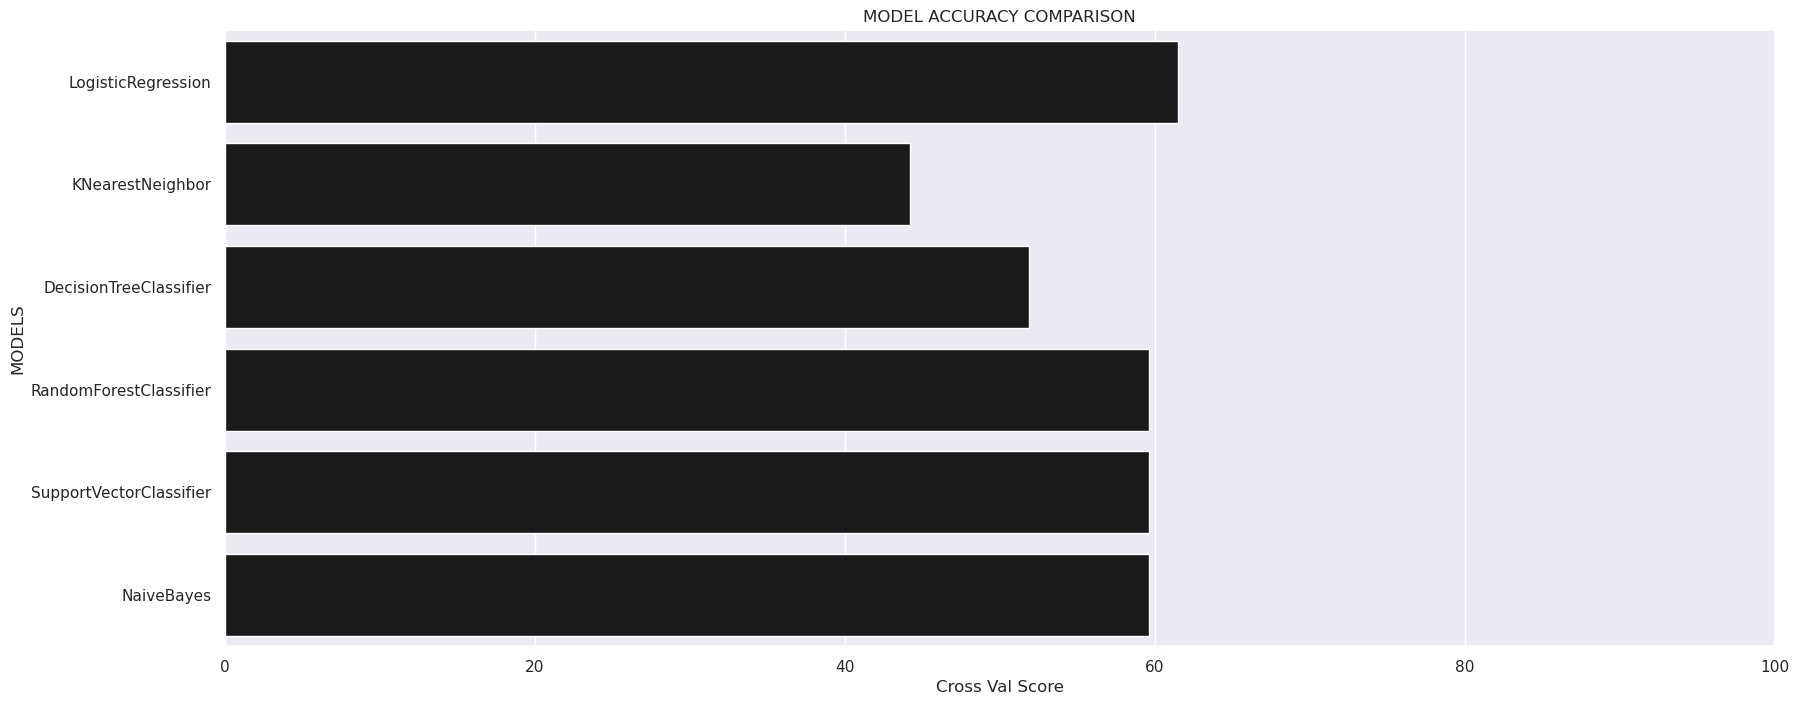

In [213]:
r = pd.DataFrame(columns=["MODELS","R2CV"])
for i, model in enumerate(modelsc):
    name = d[i]
    R2CV = cross_val_score(model, atheism_val["tweets"], atheism_val["labels"], cv=2).mean()
    result = pd.DataFrame([[name,R2CV*100]], columns=["MODELS","R2CV"])
    r = r.append(result)

figure = plt.figure(figsize=(20, 8))
sns.barplot(x="R2CV", y="MODELS", data=r, color="k")
plt.xlabel("Cross Val Score")
plt.ylabel("MODELS")
plt.xlim(0, 100)
plt.title("MODEL ACCURACY COMPARISON")
plt.show()

#### Tuning the best models

In [214]:
scores={}
accuracyscore = {}
recallscore = {}
precisionscore = {}
fscore = {}

##### Random Forest Classifier

In [215]:
RFC_noob_atheism = model_pipeline(RandomForestClassifier(random_state=42))

In [216]:
parameters = {"clf__n_estimators": [100, 500, 1000, 2000],
             "clf__max_depth": [3, 6, 12, 24, 48],
             "clf__criterion": ["gini", "entropy"],
             }

In [217]:
gs_clf = GridSearchCV(RFC_noob_atheism, parameters, cv=2, n_jobs=-1, scoring="recall_macro").fit(atheism_train["tweets"], atheism_train["labels"])

In [218]:
scores["RFC"] = gs_clf.best_score_
scores["RFC"]

0.3664877103694121

In [219]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__criterion: 'entropy'
clf__max_depth: 24
clf__n_estimators: 100


In [220]:
RFC_tuned_atheism = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x )
                         ), ('tfidf', TfidfTransformer()
                         ), ('clf', RandomForestClassifier(random_state=42, 
                                                       criterion = 'entropy', 
                                                       max_depth= 24, 
                                                       n_estimators= 100))]).fit(atheism_train["tweets"], atheism_train["labels"])

In [221]:
predict = RFC_tuned_atheism.predict(atheism_val["tweets"])
ls = list(range(0,3))
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("classes not predicted by model: {}".format(temp))
accuracyscore["RandomForestClassifier"] = accuracy_score(atheism_val["labels"], predict) 
recallscore["RandomForestClassifier"] = recall_score(atheism_val["labels"], predict, average="macro")
precisionscore["RandomForestClassifier"] = precision_score(atheism_val["labels"], predict, average="macro")
fscore["RandomForestClassifier"] = f1_score(atheism_val["labels"], predict, average="macro")

classes not predicted by model: [2]


##### Support Vector Classifier

In [222]:
SV_noob_atheism = model_pipeline(SVC(random_state=42))

In [223]:
parameters = {"clf__C": [1,3,9,27],
             "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
             "clf__degree": [1,3,9,27],
             }

In [224]:
gs_clf = GridSearchCV(SV_noob_atheism, parameters, cv=2, n_jobs=-1, scoring="recall_macro").fit(atheism_train["tweets"], atheism_train["labels"])

In [225]:
scores["SV"] = gs_clf.best_score_
scores["SV"]

0.44863010841093465

In [226]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__C: 27
clf__degree: 3
clf__kernel: 'poly'


In [227]:
SV_tuned_atheism = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None )
                     ), ('tfidf', TfidfTransformer()
                     ), ('clf', SVC(random_state=42, 
                                    C = 27, 
                                    degree= 3,
                                    kernel="poly"))]).fit(atheism_train["tweets"], atheism_train["labels"])

In [228]:
predict = SV_tuned_atheism.predict(atheism_val["tweets"])
ls = list(range(0,3))
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("classes not predicted by model: {}".format(temp))
accuracyscore["SupportVector"] = accuracy_score( atheism_val["labels"], predict) 
recallscore["SupportVector"] = recall_score(atheism_val["labels"], predict, average="macro")
precisionscore["SupportVector"] = precision_score(atheism_val["labels"], predict, average="macro")
fscore["SupportVector"] = f1_score(atheism_val["labels"], predict, average="macro")

classes not predicted by model: []


##### Logistical Regression

In [229]:
LR_noob_atheism = model_pipeline(SGDClassifier(loss='log_loss', random_state=42))

In [230]:
parameters = {"clf__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
              "clf__penalty": ["l2", "l1", "elasticnet"],
             }

In [231]:
gs_clf = GridSearchCV(LR_noob_atheism, parameters, cv=2, n_jobs=-1, scoring="recall_macro").fit(atheism_train["tweets"], atheism_train["labels"])

In [232]:
scores["LR"] = gs_clf.best_score_
scores["LR"]

0.3948566745888605

In [233]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.0003
clf__penalty: 'l1'


In [234]:
LR_tuned_atheism = Pipeline([('vect', CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, token_pattern=None )
                     ), ('tfidf', TfidfTransformer()
                     ), ('clf', SGDClassifier(loss="log",
                                    random_state=42, 
                                    alpha = 0.0003, 
                                    penalty="l1"
                                             ))]).fit(atheism_train["tweets"], atheism_train["labels"])

In [235]:
predict = LR_tuned_atheism.predict(atheism_val["tweets"])
ls = list(range(0,3))
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in uniq]
print("classes not predicted by model: {}".format(temp))
accuracyscore["LogisticRegression"]  = accuracy_score( atheism_val["labels"] , predict) 
recallscore["LogisticRegression"]    = recall_score(   atheism_val["labels"],  predict, average="macro")
precisionscore["LogisticRegression"] = precision_score(atheism_val["labels"],  predict, average="macro")
fscore["LogisticRegression"]         = f1_score(       atheism_val["labels"],  predict, average="macro")

classes not predicted by model: []


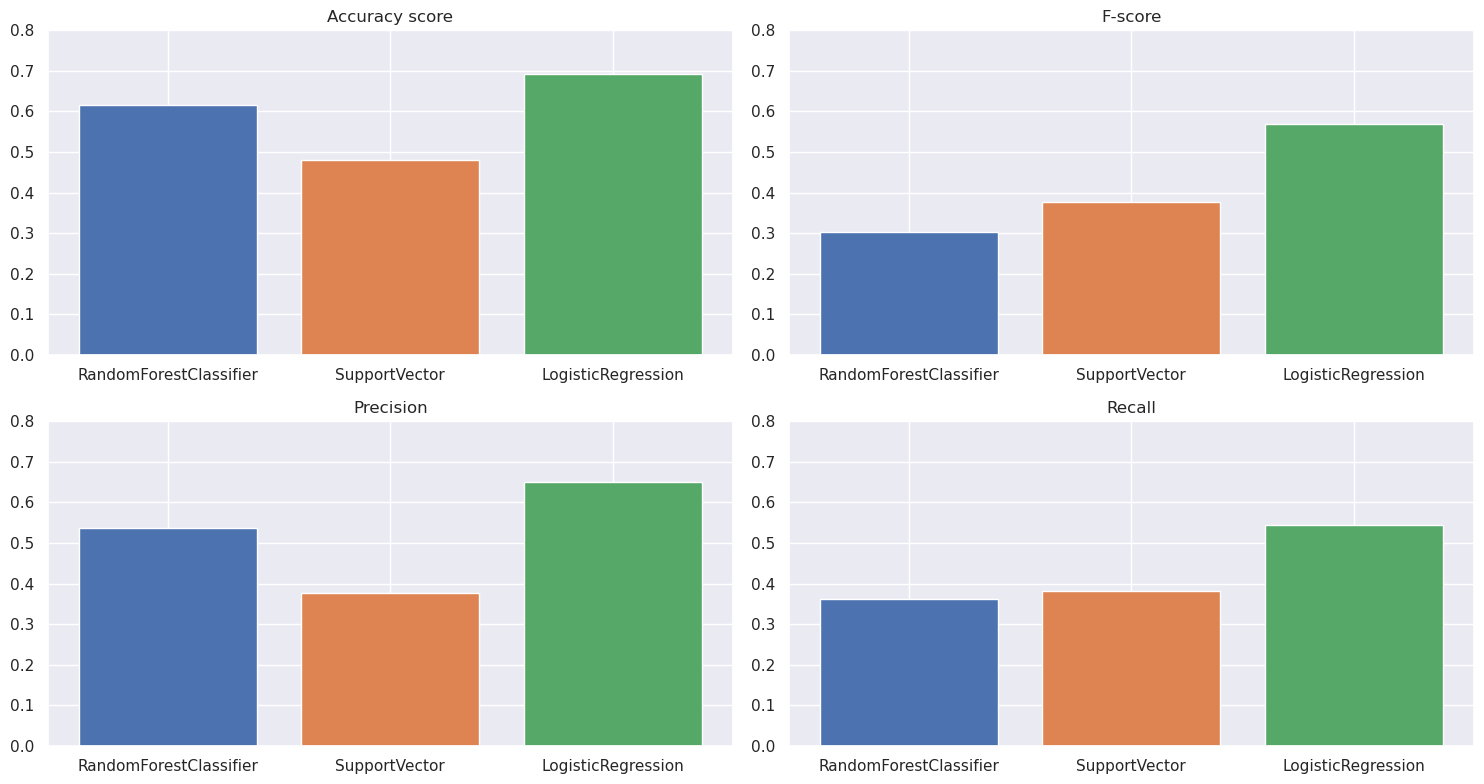

In [236]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
ax[0,0].set_title("Accuracy score")
ax[0,1].set_title("F-score")
ax[1,0].set_title("Precision")
ax[1,1].set_title("Recall")

for i in accuracyscore.items():
    ax[0,0].bar(i[0], i[1])
    ax[0,0].set_ylim([0,0.8])

for i in fscore.items():
    ax[0,1].bar(i[0], i[1])
    ax[0,1].set_ylim([0,0.8])
    
for i in precisionscore.items():
    ax[1,0].bar(i[0], i[1])
    ax[1,0].set_ylim([0,0.8])
    
for i in recallscore.items():
    ax[1,1].bar(i[0], i[1])
    ax[1,1].set_ylim([0,0.8])

plt.tight_layout()

Here we again see that the logistic regression is the best on all the metrics, thus it is our final model.

##### Final model on test data metrics

In [237]:
ls = [0,1,2]
model = LR_tuned_atheism
predict = model.predict(atheism_test["tweets"])
print("LogisticRegression" + ": ")
uniq, counts = np.unique(predict, return_counts=True)
temp = [item for item in ls if item not in set(uniq)]
print("     - classes not predicted by model: \t {}".format(temp))
print("     - accuracy score:\t   {}"  .format(accuracy_score( atheism_test["labels"], predict)))
print("     - recall score: \t   {}"   .format(recall_score(   atheism_test["labels"], predict,  average="macro")))
print("     - precision score:\t   {}" .format(precision_score(atheism_test["labels"], predict,  average="macro")))
print("     - f1 score:\t   {}"        .format(f1_score(       atheism_test["labels"], predict,  average="macro")))
print()

LogisticRegression: 
     - classes not predicted by model: 	 []
     - accuracy score:	   0.6409090909090909
     - recall score: 	   0.3354166666666667
     - precision score:	   0.3465909090909091
     - f1 score:	   0.33073166826769135



## Evaluating our tokenizers on the final ML atheism model

In [238]:
scores={}
accuracyscore = {}
recallscore = {}
precisionscore = {}
fscore = {}

### Ideal tokenizer

In [239]:
ideal_train = pd.concat([train_atheism, train_atheism_labels], axis=1)
ideal_val = pd.concat([validation_atheism, validation_atheism_labels], axis=1)
ideal_test = pd.concat([test_atheism,  test_atheism_labels],  axis=1)

In [240]:
copy_train = ideal_train
for idx, i in enumerate(copy_train["tweets"]):
    x = tokenize_ideal(i)
    ideal_train.loc[idx, ["tweets"]] = x[0]

copy_val = ideal_val
for idx, i in enumerate(copy_val["tweets"]):
    x = tokenize_ideal(i)
    ideal_val.loc[idx, ["tweets"]] = x[0]

copy_test = ideal_test
for idx, i in enumerate(copy_test["tweets"]):
    x = tokenize_ideal(i)
    ideal_test.loc[idx, ["tweets"]] = x[0]

In [241]:
predict = LR_tuned_atheism.predict(ideal_val["tweets"])
accuracyscore["ideal_tokenizer"] = accuracy_score(ideal_val["labels"], predict) 
recallscore["ideal_tokenizer"] = recall_score(ideal_val["labels"], predict, average="macro")
precisionscore["ideal_tokenizer"] = precision_score(ideal_val["labels"], predict, average="macro")
fscore["ideal_tokenizer"] = f1_score(ideal_val["labels"], predict, average="macro")

### Tokenize ekstra

In [242]:
ekstra_train = pd.concat([train_atheism, train_atheism_labels], axis=1)
ekstra_val = pd.concat([validation_atheism, validation_atheism_labels], axis=1)
ekstra_test = pd.concat([test_atheism, test_atheism_labels], axis=1)

In [243]:
copy_train = ekstra_train
for idx, i in enumerate(copy_train["tweets"]):
    x = tokenize_ekstra(i)
    ekstra_train.loc[idx, ["tweets"]] = x[0]

copy_val = ekstra_val
for idx, i in enumerate(copy_val["tweets"]):
    x = tokenize_ekstra(i)
    ekstra_val.loc[idx, ["tweets"]] = x[0]

copy_test = ekstra_test
for idx, i in enumerate(copy_test["tweets"]):
    x = tokenize_ekstra(i)
    ekstra_test.loc[idx, ["tweets"]] = x[0]

In [244]:
predict = LR_tuned_atheism.predict(ekstra_val["tweets"])
accuracyscore["ekstra_tokenizer"] = accuracy_score(ekstra_val["labels"], predict) 
recallscore["ekstra_tokenizer"] = recall_score(ekstra_val["labels"], predict, average="macro")
precisionscore["ekstra_tokenizer"] = precision_score(ekstra_val["labels"], predict, average="macro")
fscore["ekstra_tokenizer"] = f1_score(ekstra_val["labels"], predict, average="macro")

### NLTK tokenizer

In [245]:
def gold_tokenizer(line):
    tok = nltk.tokenize.TreebankWordTokenizer()
    new = ""
    for t in tok.tokenize(line):
        new = new + " " +t
    return new

In [246]:
gold_train = pd.concat([train_atheism, train_atheism_labels], axis=1)
gold_val   = pd.concat([validation_atheism, validation_atheism_labels], axis=1)
gold_test  = pd.concat([test_atheism,  test_atheism_labels],  axis=1)

In [247]:
copy_train = gold_train
for idx, i in enumerate(copy_train["tweets"]):
    x = gold_tokenizer(i)
    gold_train.loc[idx, ["tweets"]] = x

copy_val = gold_val
for idx, i in enumerate(copy_val["tweets"]):
    x = gold_tokenizer(i)
    gold_val.loc[idx, ["tweets"]] = x

copy_test = gold_test
for idx, i in enumerate(copy_test["tweets"]):
    x = gold_tokenizer(i)
    gold_test.loc[idx, ["tweets"]] = x


In [248]:
predict = LR_tuned_atheism.predict(gold_val["tweets"])
accuracyscore["nltk_tokenizer"]  = accuracy_score( gold_val["labels"] , predict) 
recallscore["nltk_tokenizer"]    = recall_score(   gold_val["labels"],  predict, average="macro")
precisionscore["nltk_tokenizer"] = precision_score(gold_val["labels"],  predict, average="macro")
fscore["nltk_tokenizer"]         = f1_score(       gold_val["labels"],  predict, average="macro")

### no tokenizer
To compare the tokenizers with the scenario where we do not use a tokenizer

In [249]:
raw_train = pd.concat([train_atheism, train_atheism_labels], axis=1)
raw_val   = pd.concat([validation_atheism, validation_atheism_labels], axis=1)
raw_test  = pd.concat([test_atheism,  test_atheism_labels],  axis=1)

In [250]:
predict = LR_tuned_atheism.predict(raw_val["tweets"])
accuracyscore["raw"]  = accuracy_score( raw_val["labels"] , predict) 
recallscore["raw"]    = recall_score(   raw_val["labels"],  predict, average="macro")
precisionscore["raw"] = precision_score(raw_val["labels"],  predict, average="macro")
fscore["raw"]         = f1_score(       raw_val["labels"],  predict, average="macro")

### Evaluatin of tokenizers

We see that all the tokenizers produce different results

In [251]:
ideal_val["tweets"].iloc[39]

'necessity is the mother of innovation our deen is complete there is no need for innovation islam semst'

In [252]:
ekstra_val["tweets"].iloc[39]

'# necessity is the mother of # innovation . our # deen is complete there is no need for innovation . # islam # semst'

In [253]:
gold_val["tweets"].iloc[39]

' # Necessity is the mother of # innovation. Our # Deen is complete - there is no need for innovation. # islam # SemST'

In [254]:
raw_val["tweets"].iloc[39]

'#Necessity is the mother of #innovation. Our #Deen is complete - there is no need for innovation. #islam #SemST '

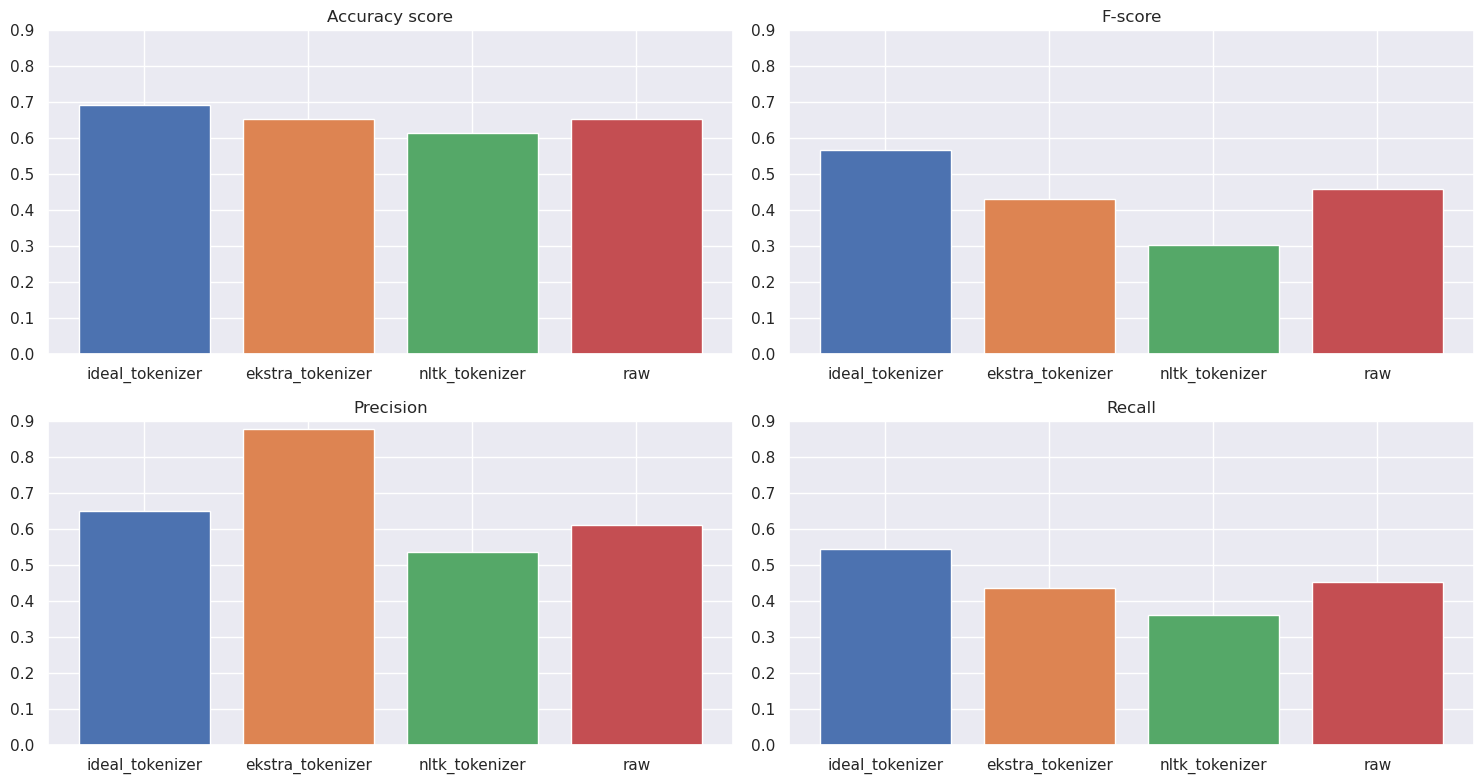

In [255]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
ax[0,0].set_title("Accuracy score")
ax[0,1].set_title("F-score")
ax[1,0].set_title("Precision")
ax[1,1].set_title("Recall")

for i in accuracyscore.items():
    ax[0,0].bar(i[0], i[1])
    ax[0,0].set_ylim([0,0.9])

for i in fscore.items():
    ax[0,1].bar(i[0], i[1])
    ax[0,1].set_ylim([0,0.9])
    
for i in precisionscore.items():
    ax[1,0].bar(i[0], i[1])
    ax[1,0].set_ylim([0,0.9])
    
for i in recallscore.items():
    ax[1,1].bar(i[0], i[1])
    ax[1,1].set_ylim([0,0.9])

plt.tight_layout()

Here we see that the tokenizer, which we have identified to be the best and most appropriate for this project, perform relatively equal to the baseline tokenizer. Oddly enough they perform as good as the raw data, which is weird. If we were to use the tokenizer implemented in CountVectorizer we would see an increase in our metrics, thus if we were to do this project for real and the rule of using our own tokenizer did not exist, then we could achieve higher accuracies.

## 5. Conclusion

For futher studies much more data would be necessary to do word embedding and in general improve our models. Especially more data in the stance-files.

```
#### Binary classification for Irony:
Final model: LogisticRegression
     - accuracy score:       0.5535714285714286
     - recall score:        0.6688102893890675
     - precision score:       0.45714285714285713
     - f1 score:       0.5430809399477806
Overall the highest accuracy score of all of the tuned models were equally bad at classifying whether a given sentence is ironic. ince the group members also performed badly at classifying irony, we can not expect the model to outperform us massively, since it lacks world knowledge and general experience and emotional aspect. 
Combining an intention model and an irony model could possibly increase the performance of the irony model.


#### Multi-class classification for Atheism:
Final model: LogisticRegression
     - classes not predicted by model:      []
     - accuracy score:       0.6409090909090909
     - recall score:        0.3354166666666667
     - precision score:       0.3465909090909091
     - f1 score:       0.33073166826769135
The model for classifying the stance in the dataset Atheism performed best out of the bunch. In the end the LogisticRegression model was chosen, as it included all labels, opposite some of the other models, and had the overall highest scores.
The distribution looked fairly linear and we had to use the macro-average recall, because the data was unbalanced - which was likely also the cause of some of the models leaving out some of the classes when predicting.


#### Multi-class classification for all stances:
Final model: KNN
     - classes not predicted by model:      []
     - accuracy score:       0.21857485988791034
     - recall score:        0.1293985722138177
     - precision score:       0.1290124308772997
     - f1 score:       0.12514616152456073
The KNN was seen as the best models, since it only excluded one classification out of the total 15 on the training data. Given the difficulty of the task with this many different classes the accuracy of the KNN is surprisingly high - better than random, yet still bad. Safe to say is that little amount of training data for some classes (imbalance) and a lot of labels to predict from is not promissing.
```

#### Evaluating tokenizer
Our final developed tokenizer performed relatively equal to the baseline tokenizer. If doing this project for real higher accuracies could be achieved if we were to use the tokenizer implemented in CountVectorizer, as this would increase our metrics.